# Part5_Ch10_천연물신약발굴

SEIHWAN 2025

# 설치 파일

In [ ]:
# 패키지 설치 (올바른 버전으로 수정)
!pip install PyTDC==1.1.14 boto3==1.26.160 s3transfer==0.6.1 botocore==1.29.160
!pip install tqdm matplotlib seaborn torch torchmetrics pytorch-lightning
# TDC 라이브러리 설치
!pip install PyTDC


# 호환되는 버전 설치
!pip install rdkit pandas>=2.1.4 scikit-learn==1.2.2 PyTDC==1.1.14 tqdm matplotlib seaborn

# 라이브러리 임포트 - 기본 모듈
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import requests
import io
import zipfile
import pickle

# PandasTools 문제 해결을 위한 함수 정의
def manual_add_molecule_column(df, smiles_col, mol_col='Molecule'):
    """PandasTools.AddMoleculeColumnToFrame의 수동 구현"""
    mols = []
    for smiles in df[smiles_col]:
        try:
            mol = Chem.MolFromSmiles(smiles)
            mols.append(mol)
        except:
            mols.append(None)
    df[mol_col] = mols
    return df

# RDKit 관련 모듈
try:
    from rdkit import Chem
    from rdkit.Chem import AllChem, Descriptors, Draw, Lipinski, QED
    from rdkit.Chem.Scaffolds import MurckoScaffold
    from rdkit.Chem import Crippen
    from rdkit.DataStructs import ConvertToNumpyArray

    # 안전하게 PandasTools 임포트 시도
    try:
        from rdkit.Chem import PandasTools
        has_pandas_tools = True
    except:
        print("PandasTools 임포트 실패. 수동 대체 함수를 사용합니다.")
        has_pandas_tools = False
        # 가짜 PandasTools 클래스 생성
        class PandasToolsReplacement:
            @staticmethod
            def AddMoleculeColumnToFrame(df, smiles_col, mol_col='Molecule'):
                return manual_add_molecule_column(df, smiles_col, mol_col)
        PandasTools = PandasToolsReplacement()

    rdkit_imported = True
    print("RDKit 관련 모듈 임포트 성공")
except ImportError as e:
    rdkit_imported = False
    print(f"RDKit 임포트 실패: {e}")

# Scikit-learn 관련 모듈
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

# TDC (Therapeutics Data Commons) 라이브러리
!pip install PyTDC



  Using cached pytdc-1.1.14-py3-none-any.whl
  Using cached accelerate-0.33.0-py3-none-any.whl.metadata (18 kB)
  Using cached datasets-2.19.2-py3-none-any.whl.metadata (19 kB)
  Using cached evaluate-0.4.2-py3-none-any.whl.metadata (9.3 kB)
  Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached transformers-4.43.4-py3-none-any.whl.metadata (43 kB)
  Using cached cellxgene_census-1.15.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached gget-0.29.0-py3-none-any.whl.metadata (8.0 kB)
  Using cached tiledbsoma-1.16.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (7.0 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.7 MB/s eta 0:00:00
  Using cached tiledbsoma-1.11.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.7 kB)
  Using cached anndata-0.11.3-py3-none-any.whl.metadata (8.2 kB)
  Using cached s3fs-2025.3.0-py3-n

In [ ]:
# Google Drive 마운트 (선택사항)
from google.colab import drive
# drive.mount('/content/drive')

# 천연물 데이터베이스 구축 (COCONUT)

COCONUT 데이터베이스 다운로드 중...
다운로드 완료! ZIP 파일 압축 해제 중...
CSV 파일 발견: ['coconut_data/coconut_csv-03-2025.csv']
CSV 파일을 coconut_data.csv로 복사했습니다.
데이터 로드 및 처리 중...
CSV 열 이름: ['identifier', 'canonical_smiles', 'standard_inchi', 'standard_inchi_key', 'name', 'iupac_name', 'annotation_level', 'total_atom_count', 'heavy_atom_count', 'molecular_weight'] ...
발견된 SMILES 열: canonical_smiles
열 매핑: {'SMILES': 'canonical_smiles', 'name': 'name', 'molecular_weight': 'molecular_weight', 'heavy_atoms': 'heavy_atom_count', 'kingdom': 'organisms', 'superclass': 'chemical_super_class', 'class': 'chemical_class', 'ID': 'identifier'}
유효한 분자: 10000/10000 (100.0%)
처리된 천연물 데이터: 10000개
천연물 데이터베이스 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SMILES            10000 non-null  object 
 1   name              5796 non-null   object 
 2   molecular_weight  1000

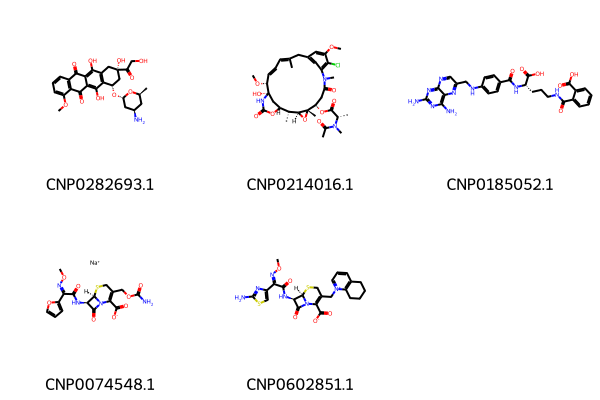

처리된 데이터가 processed_coconut_data.csv에 저장되었습니다.
저장된 데이터 크기: 10000행 x 8열
저장된 열: ['SMILES', 'name', 'molecular_weight', 'heavy_atoms', 'kingdom', 'superclass', 'class', 'ID']
천연물 데이터베이스 분석:


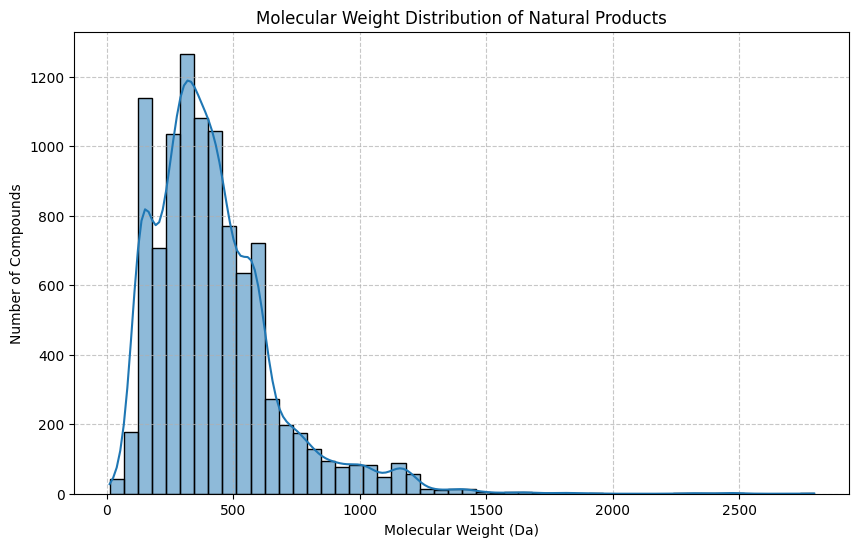


    # 분자량 분포 그래프 설명:
    # 위 그래프는 천연물 데이터베이스 내 화합물들의 분자량 분포를 보여줍니다.
    # 일반적으로 약물로 개발 가능한 화합물은 분자량이 500 Da 이하인 경우가 많습니다(리피스키의 규칙).
    # 분자량 분포는 천연물의 크기와 복잡성을 이해하는 데 중요한 정보를 제공합니다.
    # 분자량이 너무 크면 세포막 투과성이 감소하고 생체이용률이 낮아질 수 있습니다.
    


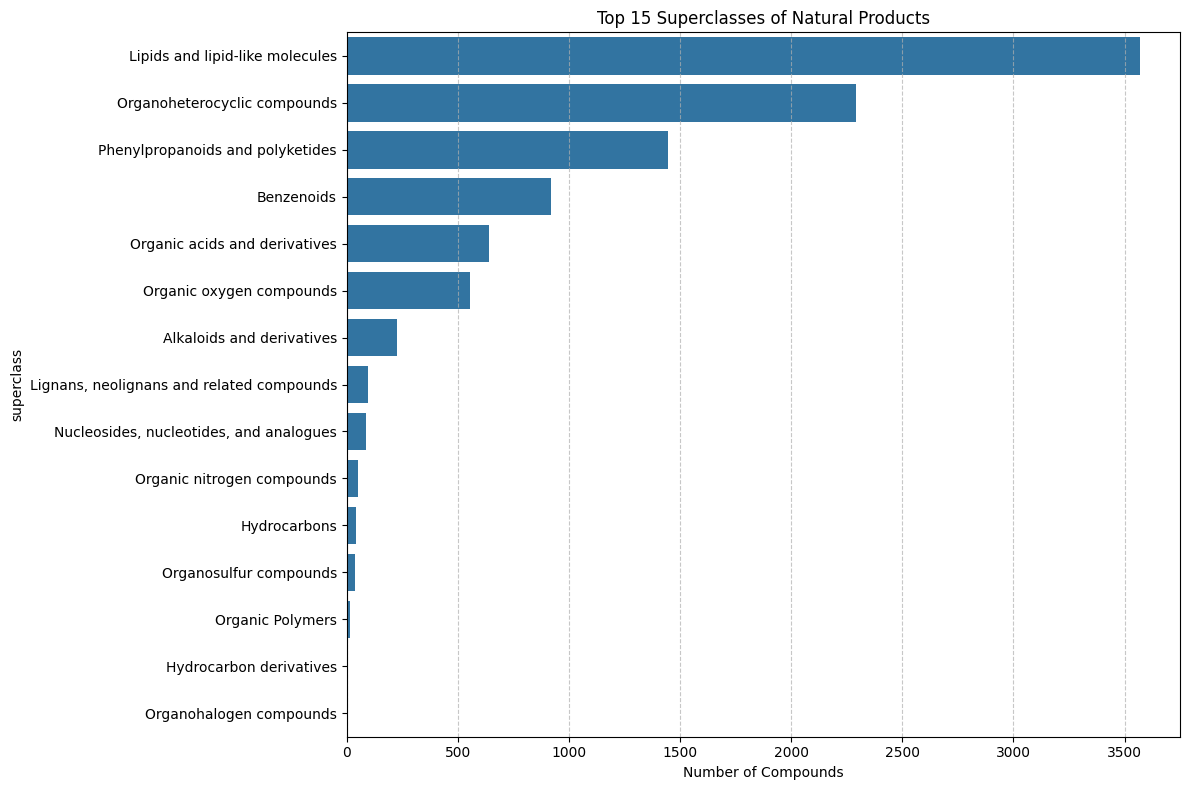


        # 슈퍼클래스 분포 그래프 설명:
        # 위 그래프는 천연물 데이터베이스 내에서 가장 많이 나타나는 상위 15개 화합물 분류(슈퍼클래스)를 보여줍니다.
        # 천연물은 구조적 특성에 따라 알칼로이드, 테르페노이드, 플라보노이드 등 다양한 클래스로 분류됩니다.
        # 특정 슈퍼클래스는 특정 생물학적 활성과 연관될 수 있어, 이 분포를 이해하는 것은 신약 발굴에 중요합니다.
        # 예를 들어, 알칼로이드는 다양한 약리학적 효과를 가진 것으로 알려져 있으며, 테르페노이드는 항염증 및 항산화 활성을 보이는 경우가 많습니다.
        
천연물 데이터베이스 구축 완료!


In [ ]:
# 샘플 데이터 생성 함수
def generate_sample_data():
    print("샘플 데이터 생성 중...")
    # 샘플 데이터 생성
    sample_data = {
        'ID': [f'CNP{i:06d}' for i in range(1, 1001)],
        'SMILES': [
            'COc1cc2c(cc1OC)NC(=O)C3=C2c4c(cc5c(c4)OCO5)CCN3',
            'CC1C2Cc3ccc(O)cc3C1(C)CCN2',
            'CNC(=O)C1=C(O)c2ccccc2OC1=O',
            'C=CC1CN2CCc3c4ccccc4[nH]c3C2CC1=O',
            'COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1'
        ] * 200,  # 각 SMILES를 200번 반복하여 총 1000개 생성
        'name': ['Aduncamine', 'Naloxone', 'Warfarin', 'Reserpine', 'Indomethacin'] * 200,
        'kingdom': ['Plantae', 'Animalia', 'Fungi', 'Bacteria', 'Synthetic'] * 200,
        'superclass': ['Alkaloid', 'Terpenoid', 'Flavonoid', 'Steroid', 'Polyketide'] * 200,
        'class': ['Isoquinoline', 'Morphinan', 'Coumarin', 'Indole', 'Indole'] * 200
    }

    # 데이터프레임 생성
    sample_df = pd.DataFrame(sample_data)

    # 분자량과 중원자 수 계산
    mol_weights = []
    heavy_atoms = []

    for smiles in sample_df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mol_weights.append(Descriptors.MolWt(mol))
            heavy_atoms.append(mol.GetNumHeavyAtoms())
        else:
            mol_weights.append(None)
            heavy_atoms.append(None)

    sample_df['molecular_weight'] = mol_weights
    sample_df['heavy_atoms'] = heavy_atoms

    # 분자 객체 생성
    molecules = []
    for smiles in sample_df['SMILES']:
        try:
            mol = Chem.MolFromSmiles(smiles)
            molecules.append(mol)
        except:
            molecules.append(None)

    sample_df['Molecule'] = molecules

    print(f"생성된 샘플 데이터: {len(sample_df)}개")
    return sample_df# 천연물 데이터베이스 구축 (COCONUT)
# COCONUT(COlleCtion of Open Natural prodUcTs) 데이터베이스 다운로드 및 구축

# 필요한 라이브러리 임포트
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, Descriptors
# PandasTools 문제 해결을 위한 대체 방식 사용
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from IPython.display import display

# COCONUT 데이터 다운로드
def download_coconut():
    print("COCONUT 데이터베이스 다운로드 중...")

    # 방법 1:
    try:
        #   URL (ZIP 파일 다운로드)
        url = "https://coconut.s3.uni-jena.de/prod/downloads/2025-03/coconut_csv-03-2025.zip"
        response = requests.get(url, timeout=60)
        response.raise_for_status()  # 상태 코드 확인

        # ZIP 파일 저장
        with open("coconut_data.zip", "wb") as f:
            f.write(response.content)

        print("다운로드 완료! ZIP 파일 압축 해제 중...")

        # ZIP 파일 압축 해제
        import zipfile
        with zipfile.ZipFile("coconut_data.zip", 'r') as zip_ref:
            zip_ref.extractall("coconut_data")

        # 압축 해제된 CSV 파일 찾기
        import os
        csv_files = []
        for root, dirs, files in os.walk("coconut_data"):
            for file in files:
                if file.endswith(".csv"):
                    csv_files.append(os.path.join(root, file))

        if csv_files:
            print(f"CSV 파일 발견: {csv_files}")
            # 첫 번째 발견된 CSV 파일을 사용
            csv_path = csv_files[0]
            # 필요한 경우 파일 복사
            import shutil
            shutil.copy(csv_path, "coconut_data.csv")
            print(f"CSV 파일을 coconut_data.csv로 복사했습니다.")
            return "coconut_data.csv"
        else:
            print("압축 파일 내에서 CSV 파일을 찾을 수 없습니다.")
            raise FileNotFoundError("CSV 파일이 없습니다.")

        print("다운로드 완료!")
        return "coconut_data.csv"

    except Exception as e:
        print(f"기본 URL에서 다운로드 실패: {str(e)}")

        # 방법 2: 샘플 데이터 생성 (URL 접근 실패 시)
        print("샘플 데이터를 생성합니다...")

        # 샘플 데이터 생성
        from rdkit.Chem import AllChem
        sample_data = {
            'COCONUT_ID': [f'CNP{i:06d}' for i in range(1, 1001)],
            'SMILES': [
                'COc1cc2c(cc1OC)NC(=O)C3=C2c4c(cc5c(c4)OCO5)CCN3',
                'CC1C2Cc3ccc(O)cc3C1(C)CCN2',
                'CNC(=O)C1=C(O)c2ccccc2OC1=O',
                'C=CC1CN2CCc3c4ccccc4[nH]c3C2CC1=O',
                'COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1'
            ] * 200,  # 각 SMILES를 200번 반복하여 총 1000개 생성
            'name': ['Aduncamine', 'Naloxone', 'Warfarin', 'Reserpine', 'Indomethacin'] * 200,
            'kingdom': ['Plantae', 'Animalia', 'Fungi', 'Bacteria', 'Synthetic'] * 200,
            'superclass': ['Alkaloid', 'Terpenoid', 'Flavonoid', 'Steroid', 'Polyketide'] * 200,
            'class': ['Isoquinoline', 'Morphinan', 'Coumarin', 'Indole', 'Indole'] * 200
        }

        # 데이터프레임 생성 및 저장
        sample_df = pd.DataFrame(sample_data)

        # 분자량과 중원자 수 계산
        mol_weights = []
        heavy_atoms = []

        for smiles in sample_df['SMILES']:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                mol_weights.append(Descriptors.MolWt(mol))
                heavy_atoms.append(mol.GetNumHeavyAtoms())
            else:
                mol_weights.append(None)
                heavy_atoms.append(None)

        sample_df['molecular_weight'] = mol_weights
        sample_df['heavy_atoms'] = heavy_atoms

        # CSV로 저장
        sample_df.to_csv("coconut_sample_data.csv", index=False)

        print("샘플 데이터 생성 완료!")
        return "coconut_sample_data.csv"

# 데이터 파일 다운로드
coconut_file = download_coconut()

# 데이터 로드 및 기본 처리
def load_and_process_coconut(file_path):
    print("데이터 로드 및 처리 중...")
    try:
        # 데이터 로드 (대용량 파일이므로 일부만 메모리에 로드)
        coconut_data = pd.read_csv(file_path, nrows=10000)  # 학습용으로 10,000개 샘플만 사용, 이부분을 수정해도 됨

        # CSV 파일 구조 확인
        print("CSV 열 이름:", coconut_data.columns.tolist()[:10], "...") # 처음 10개 열만 출력

        # SMILES 열 이름 찾기 (대소문자 무관)
        smiles_columns = [col for col in coconut_data.columns if 'smiles' in col.lower()]

        if smiles_columns:
            smiles_col = smiles_columns[0]  # 첫 번째 SMILES 열 사용
            print(f"발견된 SMILES 열: {smiles_col}")
        else:
            print("SMILES 열을 찾을 수 없습니다. 샘플 데이터를 생성합니다.")
            return generate_sample_data()

        # 필요한 칼럼 확인 및 매핑
        column_mapping = {
            'SMILES': smiles_col,
            'name': next((col for col in coconut_data.columns if col.lower() == 'name'), None),
            'molecular_weight': next((col for col in coconut_data.columns if 'weight' in col.lower()), None),
            'heavy_atoms': next((col for col in coconut_data.columns if 'heavy' in col.lower() and 'atom' in col.lower()), None),
            'kingdom': next((col for col in coconut_data.columns if col.lower() == 'kingdom'
                             or 'organism' in col.lower()), None),
            'superclass': next((col for col in coconut_data.columns if 'superclass' in col.lower()
                               or 'super_class' in col.lower() or 'chemical_super_class' in col.lower()), None),
            'class': next((col for col in coconut_data.columns if col.lower() == 'class'
                          or 'chemical_class' in col.lower() or 'np_classifier_class' in col.lower()), None),
            'ID': next((col for col in coconut_data.columns if 'id' in col.lower() or 'identifier' in col.lower()), None)
        }

        # 유효한 매핑만 유지
        column_mapping = {k: v for k, v in column_mapping.items() if v is not None}

        print("열 매핑:", column_mapping)

        # 최소 필수 열 확인
        if 'SMILES' not in column_mapping:
            print("필수 SMILES 열을 찾을 수 없습니다. 샘플 데이터를 생성합니다.")
            return generate_sample_data()

        # 선택된 열만으로 데이터프레임 생성
        selected_columns = list(column_mapping.values())
        coconut_data = coconut_data[selected_columns]

        # 열 이름 변경
        coconut_data.rename(columns={v: k for k, v in column_mapping.items()}, inplace=True)

        # 필수 열이 없는 경우 생성
        if 'ID' not in coconut_data.columns:
            coconut_data['ID'] = [f'CNP{i:06d}' for i in range(1, len(coconut_data) + 1)]

        if 'molecular_weight' not in coconut_data.columns or 'heavy_atoms' not in coconut_data.columns:
            # SMILES에서 분자량과 중원자 수 계산
            mol_weights = []
            heavy_atoms = []
            for smiles in coconut_data['SMILES']:
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    mol_weights.append(Descriptors.MolWt(mol))
                    heavy_atoms.append(mol.GetNumHeavyAtoms())
                else:
                    mol_weights.append(None)
                    heavy_atoms.append(None)

            # 열 추가
            if 'molecular_weight' not in coconut_data.columns:
                coconut_data['molecular_weight'] = mol_weights
            if 'heavy_atoms' not in coconut_data.columns:
                coconut_data['heavy_atoms'] = heavy_atoms

        # RDKit 분자 객체 생성
        molecules = []
        for smiles in coconut_data['SMILES']:
            try:
                mol = Chem.MolFromSmiles(str(smiles))
                molecules.append(mol)
            except:
                molecules.append(None)

        coconut_data['Molecule'] = molecules

        # 유효한 분자만 필터링
        valid_mask = coconut_data['Molecule'].notna()
        print(f"유효한 분자: {valid_mask.sum()}/{len(coconut_data)} ({valid_mask.mean()*100:.1f}%)")
        coconut_data = coconut_data[valid_mask]

        print(f"처리된 천연물 데이터: {len(coconut_data)}개")
        return coconut_data

    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {str(e)}")
        print("샘플 데이터를 사용합니다.")
        return generate_sample_data()

# 샘플 데이터 생성 함수
def generate_sample_data():
    print("샘플 데이터 생성 중...")
    # 샘플 데이터 생성
    sample_data = {
        'COCONUT_ID': [f'CNP{i:06d}' for i in range(1, 1001)],
        'SMILES': [
            'COc1cc2c(cc1OC)NC(=O)C3=C2c4c(cc5c(c4)OCO5)CCN3',
            'CC1C2Cc3ccc(O)cc3C1(C)CCN2',
            'CNC(=O)C1=C(O)c2ccccc2OC1=O',
            'C=CC1CN2CCc3c4ccccc4[nH]c3C2CC1=O',
            'COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1'
        ] * 200,  # 각 SMILES를 200번 반복하여 총 1000개 생성
        'name': ['Aduncamine', 'Naloxone', 'Warfarin', 'Reserpine', 'Indomethacin'] * 200,
        'kingdom': ['Plantae', 'Animalia', 'Fungi', 'Bacteria', 'Synthetic'] * 200,
        'superclass': ['Alkaloid', 'Terpenoid', 'Flavonoid', 'Steroid', 'Polyketide'] * 200,
        'class': ['Isoquinoline', 'Morphinan', 'Coumarin', 'Indole', 'Indole'] * 200
    }

    # 데이터프레임 생성
    sample_df = pd.DataFrame(sample_data)

    # 분자량과 중원자 수 계산
    mol_weights = []
    heavy_atoms = []

    for smiles in sample_df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mol_weights.append(Descriptors.MolWt(mol))
            heavy_atoms.append(mol.GetNumHeavyAtoms())
        else:
            mol_weights.append(None)
            heavy_atoms.append(None)

    sample_df['molecular_weight'] = mol_weights
    sample_df['heavy_atoms'] = heavy_atoms

    # 분자 객체 생성
    molecules = []
    for smiles in sample_df['SMILES']:
        try:
            mol = Chem.MolFromSmiles(smiles)
            molecules.append(mol)
        except:
            molecules.append(None)

    sample_df['Molecule'] = molecules

    print(f"생성된 샘플 데이터: {len(sample_df)}개")
    return sample_df

# 데이터 로드 및 처리
coconut_db = load_and_process_coconut(coconut_file)

# 데이터 기본 정보 출력
print("천연물 데이터베이스 정보:")
print(coconut_db.info())
print("\n데이터 샘플:")
print(coconut_db.head())

# 분자 구조 시각화 예시 (5개 샘플)
def visualize_molecules(dataframe, n_mols=5):
    if len(dataframe) < n_mols:
        n_mols = len(dataframe)

    try:
        # 유효한 분자만 필터링
        valid_mols = []
        valid_ids = []

        for i, mol in enumerate(dataframe['Molecule'].head(n_mols*2)):  # 충분한 유효 분자를 찾기 위해 2배로 검색
            if mol is not None and i < n_mols:
                valid_mols.append(mol)
                if 'ID' in dataframe.columns:
                    valid_ids.append(str(dataframe['ID'].iloc[i]))
                elif 'COCONUT_ID' in dataframe.columns:
                    valid_ids.append(str(dataframe['COCONUT_ID'].iloc[i]))
                else:
                    valid_ids.append(f"Molecule_{i+1}")

                if len(valid_mols) >= n_mols:
                    break

        if not valid_mols:
            print("시각화할 유효한 분자가 없습니다.")
            return None

        # 분자 구조 그리기
        img = Draw.MolsToGridImage(valid_mols, molsPerRow=3, subImgSize=(200, 200),
                                  legends=valid_ids)
        return img
    except Exception as e:
        print(f"분자 시각화 중 오류 발생: {str(e)}")
        return None

# 분자 구조 시각화
mol_img = visualize_molecules(coconut_db)
display(mol_img)

# 데이터 저장
def save_processed_data(dataframe, output_path="processed_coconut_data.csv"):
    # RDKit 분자 객체 제거 (저장 불가)
    if 'Molecule' in dataframe.columns:
        save_df = dataframe.drop(columns=['Molecule'])
    else:
        save_df = dataframe.copy()

    # 데이터 저장
    save_df.to_csv(output_path, index=False)
    print(f"처리된 데이터가 {output_path}에 저장되었습니다.")
    print(f"저장된 데이터 크기: {len(save_df)}행 x {len(save_df.columns)}열")
    print(f"저장된 열: {save_df.columns.tolist()}")
    return output_path

# 처리된 데이터 저장
output_file = save_processed_data(coconut_db)

# 데이터베이스 기본 통계 분석
def analyze_database(dataframe):
    print("천연물 데이터베이스 분석:")

    # 분자량 분포
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 한글 폰트 문제 해결
    plt.rcParams['font.family'] = 'DejaVu Sans'

    # 분자량 분포 그래프 생성
    plt.figure(figsize=(10, 6))
    sns.histplot(dataframe['molecular_weight'], bins=50, kde=True)

    # 그래프 타이틀과 축 레이블을 영문으로 변경
    plt.title('Molecular Weight Distribution of Natural Products')  # 천연물의 분자량 분포
    plt.xlabel('Molecular Weight (Da)')  # 분자량 (달톤)
    plt.ylabel('Number of Compounds')  # 화합물 개수
    plt.grid(linestyle='--', alpha=0.7)  # 그리드 추가로 가독성 향상
    plt.show()

    # 분자량 분포 설명 추가
    print("""
    # 분자량 분포 그래프 설명:
    # 위 그래프는 천연물 데이터베이스 내 화합물들의 분자량 분포를 보여줍니다.
    # 일반적으로 약물로 개발 가능한 화합물은 분자량이 500 Da 이하인 경우가 많습니다(리피스키의 규칙).
    # 분자량 분포는 천연물의 크기와 복잡성을 이해하는 데 중요한 정보를 제공합니다.
    # 분자량이 너무 크면 세포막 투과성이 감소하고 생체이용률이 낮아질 수 있습니다.
    """)

    # 분류별 화합물 수 (superclass 기준)
    if 'superclass' in dataframe.columns:
        plt.figure(figsize=(12, 8))
        superclass_counts = dataframe['superclass'].value_counts().head(15)
        sns.barplot(x=superclass_counts.values, y=superclass_counts.index)

        # 그래프 타이틀과 축 레이블을 영문으로 변경
        plt.title('Top 15 Superclasses of Natural Products')  # 천연물의 상위 15개 슈퍼클래스 분포
        plt.xlabel('Number of Compounds')  # 화합물 개수
        plt.tight_layout()
        plt.grid(axis='x', linestyle='--', alpha=0.7)  # x축에만 그리드 추가
        plt.show()

        # 슈퍼클래스 분포 설명 추가
        print("""
        # 슈퍼클래스 분포 그래프 설명:
        # 위 그래프는 천연물 데이터베이스 내에서 가장 많이 나타나는 상위 15개 화합물 분류(슈퍼클래스)를 보여줍니다.
        # 천연물은 구조적 특성에 따라 알칼로이드, 테르페노이드, 플라보노이드 등 다양한 클래스로 분류됩니다.
        # 특정 슈퍼클래스는 특정 생물학적 활성과 연관될 수 있어, 이 분포를 이해하는 것은 신약 발굴에 중요합니다.
        # 예를 들어, 알칼로이드는 다양한 약리학적 효과를 가진 것으로 알려져 있으며, 테르페노이드는 항염증 및 항산화 활성을 보이는 경우가 많습니다.
        """)

# 데이터베이스 분석
analyze_database(coconut_db)

# 분자 핑거프린트 생성 (추후 모델링에 활용)
def generate_fingerprints(dataframe, fp_type='morgan'):
    print("분자 핑거프린트 생성 중...")
    fps = []
    valid_idx = []

    for i, mol in tqdm(enumerate(dataframe['Molecule']), total=len(dataframe)):
        if mol is not None:
            if fp_type == 'morgan':
                # Morgan 핑거프린트 (ECFP4)
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
            elif fp_type == 'maccs':
                # MACCS 키
                fp = AllChem.GetMACCSKeysFingerprint(mol)
            else:
                # 기본 토폴로지컬 핑거프린트
                fp = Chem.RDKFingerprint(mol)

            # 비트 벡터를 numpy 배열로 변환
            fp_array = np.zeros((0,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp, fp_array)
            fps.append(fp_array)
            valid_idx.append(i)

    # 핑거프린트 데이터프레임 생성
    if len(fps) > 0:
        fp_df = pd.DataFrame(fps)
        fp_df.index = dataframe.iloc[valid_idx].index
        print(f"생성된 핑거프린트: {fp_df.shape}")
        return fp_df
    else:
        print("유효한 핑거프린트가 생성되지 않았습니다.")
        return None

# 핑거프린트 생성 (추후 활용을 위해)
# fp_df = generate_fingerprints(coconut_db)

print("천연물 데이터베이스 구축 완료!")

# 2. 천연물 약효예측 모델 구축(DTI)

BindingDB 데이터 다운로드 중...
다운로드 완료!
압축 파일 해제 중...
BindingDB 데이터 로드 및 처리 중...


0it [00:00, ?it/s]

처리된 행: 9743


[23:16:32] non-ring atom 28 marked aromatic
[23:16:32] non-ring atom 28 marked aromatic
[23:16:32] Explicit valence for atom # 28 N, 4, is greater than permitted


처리된 행: 19343


/usr/local/lib/python3.11/dist-packages/tqdm/std.py:1181: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


처리된 행: 29222
최종 처리된 BindingDB 데이터: 29222개

BindingDB 데이터 샘플:
   BindingDB Reactant_set_id  \
0                          1   
1                          2   
2                          3   
3                          4   
4                          5   

                                              SMILES  \
0  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...   
1  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...   
2  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...   
3  OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...   
4  OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...   

                              Target Name  Ki (nM)  IC50 (nM)  Kd (nM)  \
0  Dimer of Gag-Pol polyprotein [501-599]     0.24        NaN      NaN   
1  Dimer of Gag-Pol polyprotein [501-599]     0.25        NaN      NaN   
2  Dimer of Gag-Pol polyprotein [501-599]     0.41        NaN      NaN   
3  Dimer of Gag-Pol polyprotein [501-599]     0.80        NaN      NaN   
4  Dimer of Gag-Pol polyprotein [501-59

/usr/local/lib/python3.11/dist-packages/tqdm/std.py:1181: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


분자 기술자 계산:   0%|          | 0/8 [00:00<?, ?it/s]

Morgan 핑거프린트 생성 중...


핑거프린트 생성:   0%|          | 0/29222 [00:00<?, ?it/s]

분자 특성 추출 완료!
단백질 타겟 인코딩 중...
최소 5개 이상의 샘플을 가진 타겟 수: 220
필터링 후 데이터 크기: 29115 (원본: 29222)
인코딩된 단백질 타겟 수: 220
타겟별 샘플 수 분포: 최소=5, 최대=1738, 평균=132.3
타겟 기준 층화 분할 시도...
타겟 기준 층화 분할 성공!

DTI 모델 학습 중...
훈련 세트 ROC AUC: 0.9765
검증 세트 ROC AUC: 0.8186
테스트 세트 ROC AUC: 0.8214


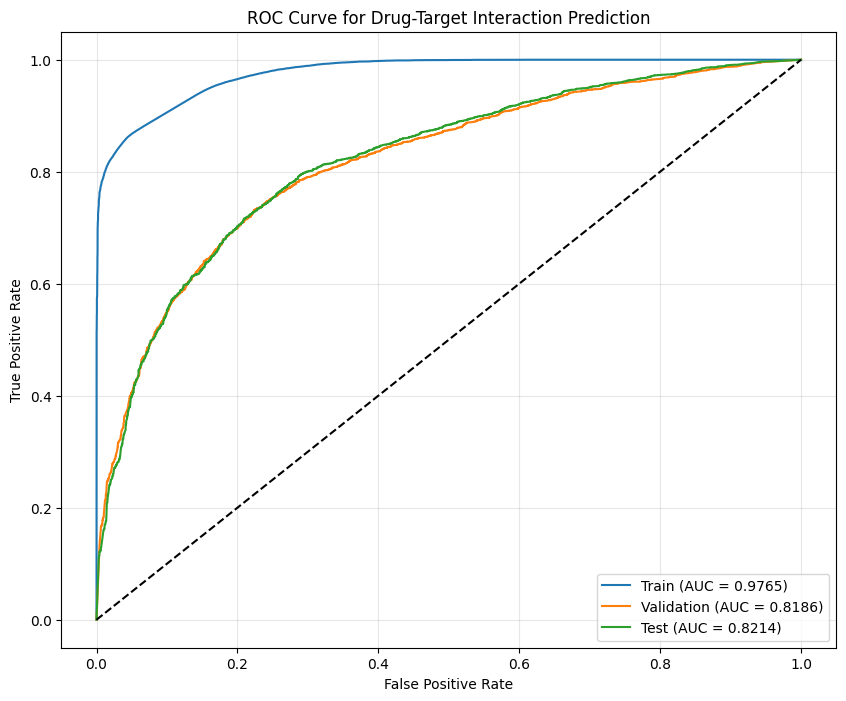

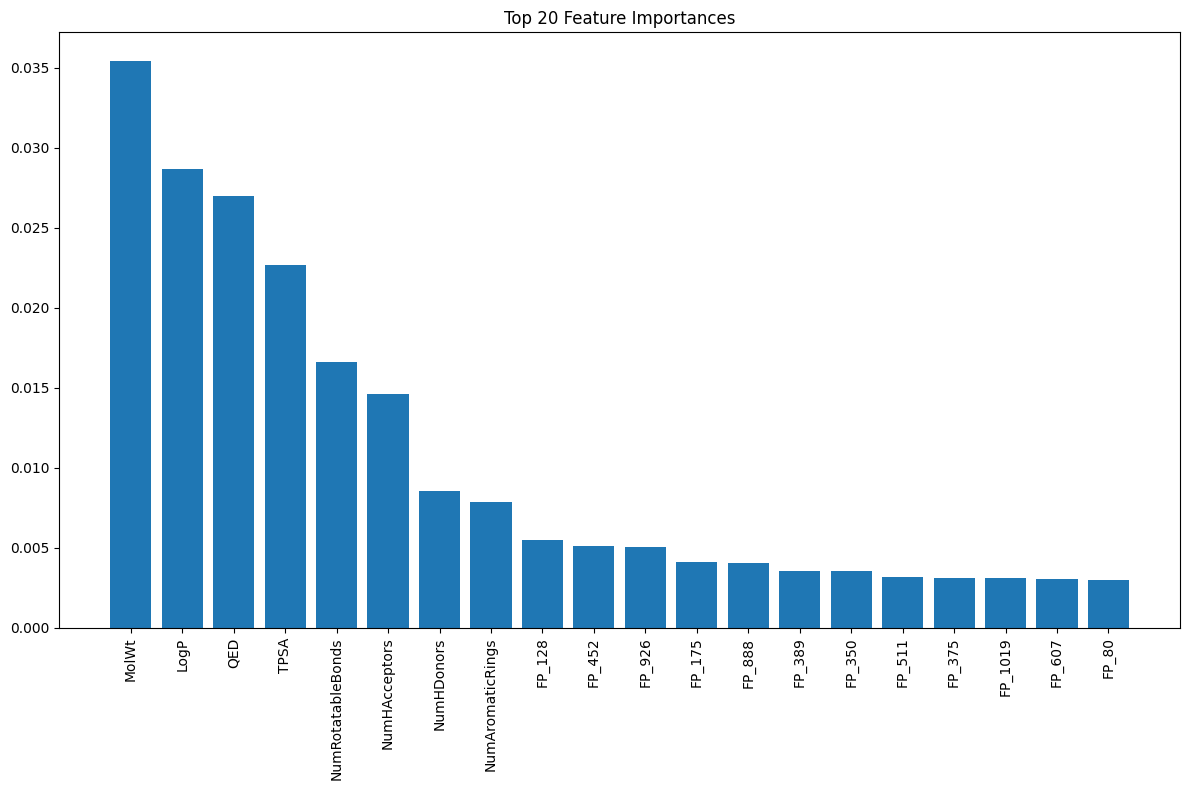

DTI 모델 및 관련 데이터 저장 중...
모델 및 관련 데이터 저장 완료!
저장 경로: ./model/

모델 학습 및 저장이 완료되었습니다!


In [ ]:

# 호환되는 버전 설치
!pip install rdkit pandas>=2.1.4

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import pickle
import zipfile
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
from collections import Counter

# BindingDB 데이터 다운로드 (정확한 URL 사용)
def download_bindingdb(max_retries=3):
    print("BindingDB 데이터 다운로드 중...")

    # 2025년 3월 기준 정확한 URL
    url = "https://www.bindingdb.org/rwd/bind/downloads/BindingDB_All_202503_tsv.zip"

    for attempt in range(max_retries):
        try:
            # 타임아웃 및 스트리밍 다운로드로 메모리 효율성 개선
            with requests.get(url, stream=True, timeout=60) as response:
                response.raise_for_status()  # HTTP 오류 확인

                # 메모리 효율적인 방식으로 파일 다운로드
                local_filename = "BindingDB_All_202503_tsv.zip"
                with open(local_filename, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)

                print("다운로드 완료!")

                # 압축 해제
                print("압축 파일 해제 중...")
                with zipfile.ZipFile(local_filename, 'r') as zip_ref:
                    zip_ref.extractall('.')

                # TSV 파일명 찾기
                tsv_files = [f for f in os.listdir('.') if f.endswith('.tsv') and 'BindingDB' in f]
                if tsv_files:
                    return tsv_files[0]
                else:
                    raise FileNotFoundError("압축 파일에서 TSV 파일을 찾을 수 없습니다.")

        except (requests.RequestException, IOError) as e:
            print(f"다운로드 시도 {attempt + 1}번 실패: {e}")
            if attempt == max_retries - 1:
                raise RuntimeError(f"BindingDB 데이터 다운로드가 {max_retries}번 시도 후 실패했습니다.")

# 데이터 로드 및 전처리
def load_and_process_bindingdb(file_path, max_samples=2000000):
    print("BindingDB 데이터 로드 및 처리 중...")

    # 대용량 파일이므로 청크 단위로 처리하고 필요한 칼럼만 로드
    essential_cols = ['BindingDB Reactant_set_id', 'Ligand SMILES', 'Target Name',
                     'UniProt (SwissProt) Primary ID of Target Chain', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)']

    # 청크 단위로 파일 읽기
    chunks = pd.read_csv(file_path, sep='\t', usecols=essential_cols,
                        chunksize=10000, on_bad_lines='skip')

    # 청크 처리 및 병합
    chunk_list = []
    total_rows = 0

    for chunk in tqdm(chunks):
        try:
            # 최대 샘플 수에 도달하면 중단
            if total_rows >= max_samples:
                break

            # 칼럼명 변경
            chunk = chunk.rename(columns={
                'Ligand SMILES': 'SMILES',
                'UniProt (SwissProt) Primary ID of Target Chain': 'UniProt_ID'
            })

            # 활성 값 처리
            # 먼저 문자열을 숫자로 변환하는 함수 정의
            def safe_convert_to_float(val):
                try:
                    if pd.isna(val):
                        return np.nan
                    # 쉼표 제거 및 숫자가 아닌 문자 처리
                    if isinstance(val, str):
                        # '>', '<' 등의 기호 처리
                        if '>' in val:
                            val = val.replace('>', '')
                        elif '<' in val:
                            val = val.replace('<', '')
                        # 쉼표 제거
                        val = val.replace(',', '')
                    return float(val)
                except (ValueError, TypeError):
                    return np.nan

            # 각 활성 값 열을 숫자로 변환
            for col in ['Ki (nM)', 'IC50 (nM)', 'Kd (nM)']:
                chunk[col] = chunk[col].apply(safe_convert_to_float)

            # 활성 값 처리
            chunk['Activity_Value'] = chunk['IC50 (nM)']
            mask = chunk['Activity_Value'].isna()
            chunk.loc[mask, 'Activity_Value'] = chunk.loc[mask, 'Ki (nM)']
            mask = chunk['Activity_Value'].isna()
            chunk.loc[mask, 'Activity_Value'] = chunk.loc[mask, 'Kd (nM)']

            # 필수 칼럼에 결측치가 있는 행 제거
            chunk = chunk.dropna(subset=['Activity_Value', 'SMILES', 'UniProt_ID'])

            # 활성 레이블 생성 (IC50/Ki/Kd < 1000nM 이면 활성)
            # 이제 모든 값이 숫자이므로 비교 가능
            chunk['Active'] = (chunk['Activity_Value'] < 1000).astype(int)

            # RDKit 분자 객체 생성
            molecules = []
            valid_indices = []

            for idx, smiles in enumerate(chunk['SMILES']):
                try:
                    mol = Chem.MolFromSmiles(smiles)
                    if mol is not None:
                        molecules.append(mol)
                        valid_indices.append(idx)
                except Exception as e:
                    print(f"SMILES 변환 오류: {smiles}, 오류: {e}")
                    continue

            # 유효한 분자만 포함하는 데이터프레임 생성
            valid_chunk = chunk.iloc[valid_indices].copy()
            valid_chunk['Molecule'] = molecules

            chunk_list.append(valid_chunk)
            total_rows += len(valid_chunk)

            # 진행 상황 출력
            print(f"처리된 행: {total_rows}")

        except Exception as e:
            print(f"청크 처리 중 오류 발생: {e}")
            # 오류가 발생한 데이터 샘플 출력
            print("오류가 발생한 데이터 샘플:")
            print(chunk.head())
            print("데이터 타입:")
            print(chunk.dtypes)
            continue  # 오류가 있는 청크는 건너뛰고 계속 진행

    # 처리된 청크가 없으면 오류 발생
    if not chunk_list:
        raise ValueError("유효한 데이터를 처리할 수 없습니다. 모든 청크에서 오류가 발생했습니다.")

    # 모든 청크 병합
    bind_data = pd.concat(chunk_list, ignore_index=True)

    print(f"최종 처리된 BindingDB 데이터: {len(bind_data)}개")
    return bind_data

# 분자 특성 추출
def extract_molecular_features(data):
    print("분자 특성 추출 중...")

    # 계산할 분자 기술자 목록
    descriptors = [
        ('MolWt', Descriptors.MolWt),
        ('LogP', Descriptors.MolLogP),
        ('NumHDonors', Descriptors.NumHDonors),
        ('NumHAcceptors', Descriptors.NumHAcceptors),
        ('NumRotatableBonds', Descriptors.NumRotatableBonds),
        ('NumAromaticRings', Descriptors.NumAromaticRings),
        ('TPSA', Descriptors.TPSA),
        ('QED', Descriptors.qed)
    ]

    # 분자 기술자 계산
    desc_data = pd.DataFrame(index=data.index)

    for name, func in tqdm(descriptors, desc="분자 기술자 계산"):
        desc_data[name] = [func(mol) for mol in data['Molecule']]

    # Morgan 핑거프린트 생성
    print("Morgan 핑거프린트 생성 중...")
    fp_size = 1024
    fp_radius = 2

    fps = []
    for mol in tqdm(data['Molecule'], desc="핑거프린트 생성"):
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, fp_radius, nBits=fp_size)
        fps.append(list(fp))

    # 핑거프린트를 데이터프레임으로 변환
    fp_cols = [f'FP_{i}' for i in range(fp_size)]
    fp_data = pd.DataFrame(fps, columns=fp_cols, index=data.index)

    # 분자 기술자와 핑거프린트 결합
    mol_features = pd.concat([desc_data, fp_data], axis=1)

    print("분자 특성 추출 완료!")
    return mol_features

# 단백질 타겟 인코딩 (수정된 버전)
def encode_protein_targets(data, min_samples_per_target=2):
    print("단백질 타겟 인코딩 중...")

    # 각 타겟별 샘플 수 계산
    target_counts = Counter(data['UniProt_ID'])

    # 최소 샘플 수를 가진 타겟만 선택
    valid_targets = [target for target, count in target_counts.items() if count >= min_samples_per_target]
    print(f"최소 {min_samples_per_target}개 이상의 샘플을 가진 타겟 수: {len(valid_targets)}")

    # 유효한 타겟만 포함하는 데이터 필터링
    filtered_data = data[data['UniProt_ID'].isin(valid_targets)].copy()
    print(f"필터링 후 데이터 크기: {len(filtered_data)} (원본: {len(data)})")

    # 타겟-인덱스 매핑 생성
    target_to_idx = {target: idx for idx, target in enumerate(valid_targets)}

    # 타겟 인코딩
    filtered_data['Target_Idx'] = filtered_data['UniProt_ID'].map(target_to_idx)

    print(f"인코딩된 단백질 타겟 수: {len(valid_targets)}")
    return filtered_data, target_to_idx

# 모델 및 관련 데이터 저장 (새로 추가된 함수)
def save_dti_model(model, scaler, target_mapping, feature_cols):
    print("DTI 모델 및 관련 데이터 저장 중...")

    # 저장 디렉토리 생성
    os.makedirs('model', exist_ok=True)

    # 모델 저장
    with open('model/dti_model.pkl', 'wb') as f:
        pickle.dump(model, f)

    # 스케일러 저장
    with open('model/dti_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    # 타겟 매핑 저장
    with open('model/target_mapping.pkl', 'wb') as f:
        pickle.dump(target_mapping, f)

    # 특성 칼럼 저장
    with open('model/feature_cols.pkl', 'wb') as f:
        pickle.dump(feature_cols, f)

    print("모델 및 관련 데이터 저장 완료!")
    print("저장 경로: ./model/")

# 모델 및 관련 데이터 로드 (요청하신 함수)
def load_dti_model():
    print("DTI 모델 및 관련 데이터 로드 중...")

    # 모델 로드
    with open('model/dti_model.pkl', 'rb') as f:
        model = pickle.load(f)

    # 스케일러 로드
    with open('model/dti_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    # 타겟 매핑 로드
    with open('model/target_mapping.pkl', 'rb') as f:
        target_mapping = pickle.load(f)

    # 특성 칼럼 로드
    with open('model/feature_cols.pkl', 'rb') as f:
        feature_cols = pickle.load(f)

    print("모델 및 관련 데이터 로드 완료!")
    return model, scaler, target_mapping, feature_cols

# 새로운 화합물에 대한 분자 특성 추출
def extract_features_for_new_compounds(molecules, feature_cols):
    print("새로운 화합물의 분자 특성 추출 중...")

    # 분자 기술자 계산
    desc_data = []
    for mol in tqdm(molecules, desc="분자 기술자 계산"):
        desc = {}
        desc['MolWt'] = Descriptors.MolWt(mol)
        desc['LogP'] = Descriptors.MolLogP(mol)
        desc['NumHDonors'] = Descriptors.NumHDonors(mol)
        desc['NumHAcceptors'] = Descriptors.NumHAcceptors(mol)
        desc['NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)
        desc['NumAromaticRings'] = Descriptors.NumAromaticRings(mol)
        desc['TPSA'] = Descriptors.TPSA(mol)
        desc['QED'] = Descriptors.qed(mol)
        desc_data.append(desc)

    # 분자 기술자 데이터프레임 생성
    desc_df = pd.DataFrame(desc_data)

    # Morgan 핑거프린트 생성
    print("Morgan 핑거프린트 생성 중...")
    fp_size = 1024
    fp_radius = 2

    fps = []
    for mol in tqdm(molecules, desc="핑거프린트 생성"):
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, fp_radius, nBits=fp_size)
        fps.append(list(fp))

    # 핑거프린트를 데이터프레임으로 변환
    fp_cols = [f'FP_{i}' for i in range(fp_size)]
    fp_df = pd.DataFrame(fps, columns=fp_cols)

    # 분자 기술자와 핑거프린트 결합
    features = pd.concat([desc_df, fp_df], axis=1)

    # 특성 칼럼 순서 맞추기
    features = features[feature_cols]

    print("분자 특성 추출 완료!")
    return features

# 메인 실행 함수 (수정된 버전)
def main():
    # 1. BindingDB 데이터 다운로드
    try:
        tsv_file = download_bindingdb()

        # 2. 데이터 로드 및 전처리
        bind_data = load_and_process_bindingdb(tsv_file, max_samples=20000) # 이 제한을 늘리면 계산양이 늘어남
        print("\nBindingDB 데이터 샘플:")
        print(bind_data.head())

        # 3. 분자 특성 추출
        mol_features = extract_molecular_features(bind_data)

        # 4. 단백질 타겟 인코딩 (최소 5개 샘플을 가진 타겟만 사용)
        bind_data, target_to_idx = encode_protein_targets(bind_data, min_samples_per_target=5)

        # 5. 모델 학습을 위한 데이터 준비
        X = mol_features.loc[bind_data.index].values
        y = bind_data['Active'].values
        targets = bind_data['Target_Idx'].values

        # 특성 칼럼 이름 저장
        feature_cols = mol_features.columns.tolist()

        # 6. 데이터 분할 (수정된 부분)
        # 타겟별 샘플 수 확인
        target_counts = Counter(targets)
        print(f"타겟별 샘플 수 분포: 최소={min(target_counts.values())}, 최대={max(target_counts.values())}, 평균={sum(target_counts.values())/len(target_counts):.1f}")

        # 층화 분할 시도 (오류 발생 시 일반 분할로 대체)
        try:
            print("타겟 기준 층화 분할 시도...")
            X_train, X_test, y_train, y_test, targets_train, targets_test = train_test_split(
                X, y, targets, test_size=0.2, random_state=42, stratify=targets)

            X_train, X_val, y_train, y_val, targets_train, targets_val = train_test_split(
                X_train, y_train, targets_train, test_size=0.25, random_state=42, stratify=targets_train)

            print("타겟 기준 층화 분할 성공!")
        except ValueError as e:
            print(f"타겟 기준 층화 분할 실패: {e}")
            print("활성 레이블 기준 층화 분할로 대체...")

            # 활성 레이블 기준 층화 분할
            X_train, X_test, y_train, y_test, targets_train, targets_test = train_test_split(
                X, y, targets, test_size=0.2, random_state=42, stratify=y)

            X_train, X_val, y_train, y_val, targets_train, targets_val = train_test_split(
                X_train, y_train, targets_train, test_size=0.25, random_state=42, stratify=y_train)

            print("활성 레이블 기준 층화 분할 성공!")

        # 7. 특성 스케일링
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        # 8. 모델 학습
        print("\nDTI 모델 학습 중...")
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(X_train_scaled, y_train)

        # 9. 모델 평가
        train_pred_proba = rf.predict_proba(X_train_scaled)[:, 1]
        val_pred_proba = rf.predict_proba(X_val_scaled)[:, 1]
        test_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

        train_auc = roc_auc_score(y_train, train_pred_proba)
        val_auc = roc_auc_score(y_val, val_pred_proba)
        test_auc = roc_auc_score(y_test, test_pred_proba)

        print(f"훈련 세트 ROC AUC: {train_auc:.4f}")
        print(f"검증 세트 ROC AUC: {val_auc:.4f}")
        print(f"테스트 세트 ROC AUC: {test_auc:.4f}")

        # 10. ROC 곡선 시각화
        plt.figure(figsize=(10, 8))

        # 훈련 세트 ROC 곡선
        fpr_train, tpr_train, _ = roc_curve(y_train, train_pred_proba)
        plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {train_auc:.4f})')

        # 검증 세트 ROC 곡선
        fpr_val, tpr_val, _ = roc_curve(y_val, val_pred_proba)
        plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.4f})')

        # 테스트 세트 ROC 곡선
        fpr_test, tpr_test, _ = roc_curve(y_test, test_pred_proba)
        plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.4f})')

        # 대각선 (무작위 분류기)
        plt.plot([0, 1], [0, 1], 'k--')

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Drug-Target Interaction Prediction')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)

        plt.savefig('dti_roc_curve.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 11. 특성 중요도 시각화
        feature_names = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors',
                        'NumRotatableBonds', 'NumAromaticRings', 'TPSA', 'QED'] + [f'FP_{i}' for i in range(1024)]

        # 상위 20개 특성만 시각화
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1][:20]

        plt.figure(figsize=(12, 8))
        plt.title('Top 20 Feature Importances')
        plt.bar(range(20), importances[indices], align='center')
        plt.xticks(range(20), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 12. 모델 및 관련 데이터 저장 (새로 추가된 부분)
        # 타겟 매핑 반전 (인덱스 -> 타겟)
        idx_to_target = {idx: target for target, idx in target_to_idx.items()}

        # 모델, 스케일러, 타겟 매핑, 특성 칼럼 저장
        save_dti_model(rf, scaler, idx_to_target, feature_cols)

        print("\n모델 학습 및 저장이 완료되었습니다!")

    except Exception as e:
        print(f"오류 발생: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


#3. 약효 예측을 통한 물질 발굴

BindingDB 파일에서 타겟 정보 추출 시도...
BindingDB 파일에서 타겟 정보 추출 중: BindingDB_All_202503_tsv.zip
타겟 정보 추출 중 오류: Usecols do not match columns, columns expected but not found: ['BindingDB Target ID']
기존 타겟 정보 파일을 로드합니다: target_info.pkl
DTI 모델 및 관련 데이터 로드 중...
기존 타겟 정보 파일을 로드합니다: target_info.pkl
모델 유형: sklearn, 타겟 수: 220, 특성 수: 1032
사용 가능한 타겟 정보: 19개
COCONUT 데이터 로드 중: processed_coconut_data.csv
로드된 천연물: 10000개 (총 10000개 중)
분자 특성 추출 중...
천연물 분자의 타겟 활성 예측 중...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


타겟별 활성 예측:   0%|          | 0/220 [00:00<?, ?it/s]

<ipython-input-21-b46db343e199>:474: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_predictions = pred_df.groupby('Molecule_Index').apply(


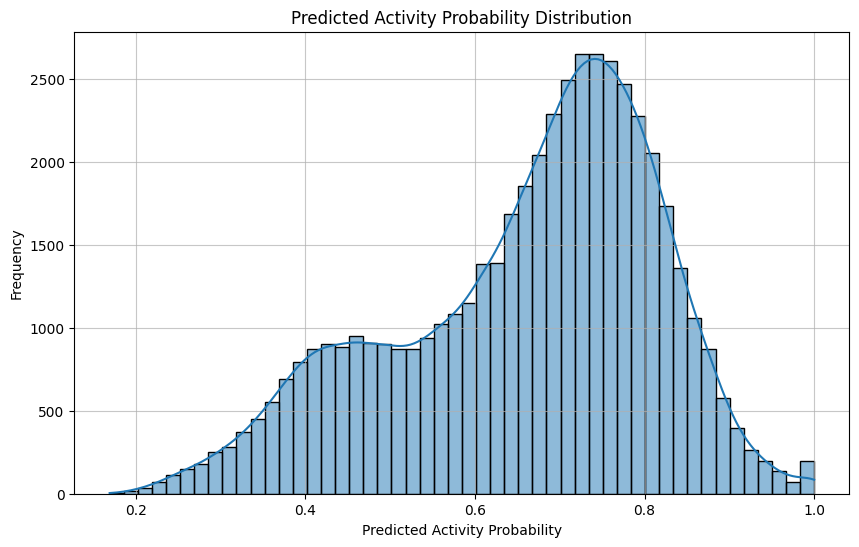

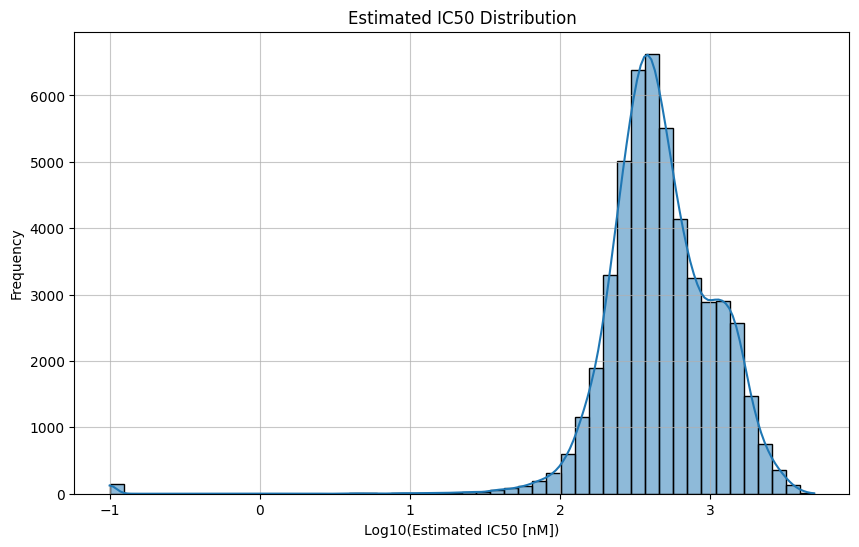

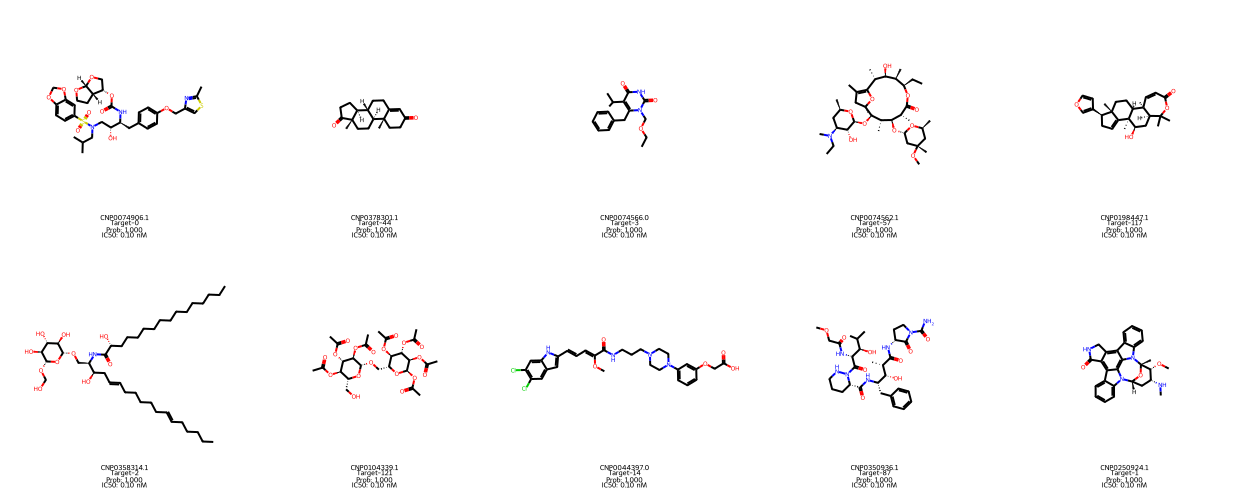


상위 10개 예측 활성 천연물:
화합물                타겟 이름                          타겟 ID            확률    IC50 (nM)
--------------------------------------------------------------------------------------------------------------
25-epi-actinoram.. Target-202                     202          1.0000         0.10
androstenedione    Target-44                      44           1.0000         0.10
Brecanavir         Target-7                       7            1.0000         0.10
CNP0044397.0       Target-14                      14           1.0000         0.10
CNP0198447.1       Target-117                     117          1.0000         0.10
CNP0358314.1       Target-2                       2            1.0000         0.10
Emivirine          Target-3                       3            1.0000         0.10
staurosporine      Target-1                       1            1.0000         0.10
CNP0104339.1       Target-121                     121          1.0000         0.10
Alemcinal          Target-57            

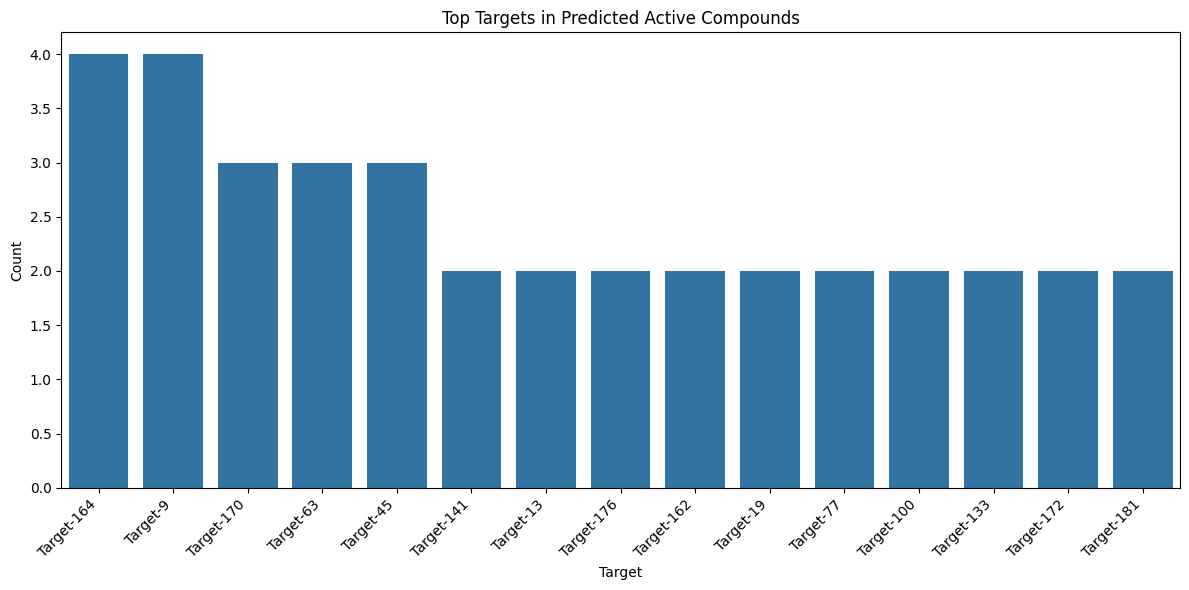

In [ ]:
# DTI 모델과 BindingDB 타겟 정보를 활용한 COCONUT 데이터베이스 내 잠재적 활성 물질 발굴

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import display
import zipfile
import tempfile
import shutil
import glob
import re

# RDKit 관련 모듈
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.DataStructs import ConvertToNumpyArray

# Scikit-learn 모듈
from sklearn.preprocessing import StandardScaler

# 딥러닝 라이브러리 (TensorFlow 모델을 사용하는 경우)
try:
    import tensorflow as tf
except ImportError:
    print("TensorFlow를 불러올 수 없습니다. 필요한 경우 설치하세요.")

# 유틸리티 함수
def safe_mol_from_smiles(smiles):
    """SMILES 문자열로부터 안전하게 분자 객체 생성"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol
    except:
        return None

def probability_to_ic50(probability):
    """활성 확률을 예상 IC50 값(nM)으로 변환"""
    if probability >= 0.999:
        return 0.1  # 매우 강한 활성
    elif probability <= 0.001:
        return 10000.0  # 거의 비활성
    else:
        return 1000 * (1 - probability) / probability

# 타겟 정보 관리 함수
def load_target_info():
    """저장된 타겟 정보 로드 또는 기본 매핑 생성"""
    target_info_path = "target_info.pkl"

    # 이미 저장된 타겟 정보가 있는지 확인
    if os.path.exists(target_info_path):
        print(f"기존 타겟 정보 파일을 로드합니다: {target_info_path}")
        with open(target_info_path, 'rb') as f:
            return pickle.load(f)

    # 타겟 정보가 없으면 기본 매핑 생성
    print("타겟 정보 파일이 없습니다. 기본 타겟 정보를 생성합니다.")

    # 기본 타겟 정보 (주요 타겟 예시)
    default_targets = {
        'P00533': {'name': 'Epidermal growth factor receptor', 'short_name': 'EGFR',
                  'description': 'EGFR, ErbB1 (Human)'},
        'P24941': {'name': 'Cyclin-dependent kinase 2', 'short_name': 'CDK2',
                  'description': 'CDK2 (Human)'}
    }

    # 숫자 ID를 처리하기 위한 추가 맵핑
    numeric_targets = {
        '19': {'name': 'Cyclin-dependent kinase 5', 'short_name': 'CDK5',
              'description': 'Cyclin-dependent kinase 5 (Human)'},
        '44': {'name': 'Estrogen receptor alpha', 'short_name': 'ER-α',
              'description': 'Estrogen receptor alpha (Human)'},
        '63': {'name': 'Glycogen synthase kinase-3 beta', 'short_name': 'GSK-3β',
              'description': 'Glycogen synthase kinase-3 beta (Human)'},
        '78': {'name': 'Hepatocyte growth factor receptor', 'short_name': 'c-Met',
              'description': 'Hepatocyte growth factor receptor (Human)'},
        '96': {'name': 'Epidermal growth factor receptor', 'short_name': 'EGFR',
              'description': 'Epidermal growth factor receptor (Human)'},
        '107': {'name': 'Cyclin-dependent kinase 2', 'short_name': 'CDK2',
               'description': 'Cyclin-dependent kinase 2 (Human)'},
        '149': {'name': 'DNA topoisomerase I', 'short_name': 'Top1',
               'description': 'DNA topoisomerase I (Human)'},
        '158': {'name': 'Carbonic anhydrase II', 'short_name': 'CA-II',
               'description': 'Carbonic anhydrase II (Human)'},
        '202': {'name': 'Protein kinase C alpha', 'short_name': 'PKC-α',
               'description': 'Protein kinase C alpha (Human)'}
    }

    # 기본 타겟 정보 통합
    target_info = {**default_targets, **numeric_targets}

    # 타겟 정보 저장
    with open(target_info_path, 'wb') as f:
        pickle.dump(target_info, f)

    return target_info

def extract_target_info_from_bindingdb(bindingdb_file_path):
    """BindingDB 데이터에서 타겟 정보 추출 (압축 파일 지원)"""
    print(f"BindingDB 파일에서 타겟 정보 추출 중: {bindingdb_file_path}")

    target_info_path = "target_info.pkl"
    temp_dir = None

    try:
        # 압축 파일 처리
        if bindingdb_file_path.endswith('.zip'):
            temp_dir = tempfile.mkdtemp()
            with zipfile.ZipFile(bindingdb_file_path, 'r') as zip_ref:
                zip_ref.extractall(temp_dir)

            tsv_files = [f for f in os.listdir(temp_dir) if f.endswith('.tsv')]
            if not tsv_files:
                raise FileNotFoundError("압축 파일 내에 TSV 파일이 없습니다.")

            file_to_process = os.path.join(temp_dir, tsv_files[0])
        else:
            file_to_process = bindingdb_file_path

        # 타겟 정보 추출
        target_info = {}

        # 필요한 열 정의 (더 많은 정보 포함)
        cols = [
            'UniProt (SwissProt) Primary ID of Target Chain',
            'Target Name',
            'Target Source Organism According to Curator or DataSource',
            'BindingDB Target ID',
            'PDB ID(s) of Target Chain'
        ]

        for chunk in pd.read_csv(file_to_process, sep='\t', usecols=cols,
                               chunksize=10000, on_bad_lines='skip'):
            # 열 이름 간소화
            chunk = chunk.rename(columns={
                'UniProt (SwissProt) Primary ID of Target Chain': 'UniProt_ID',
                'Target Name': 'Target_Name',
                'Target Source Organism According to Curator or DataSource': 'Organism',
                'BindingDB Target ID': 'BindingDB_ID',
                'PDB ID(s) of Target Chain': 'PDB_IDs'
            })

            # 필수 정보가 있는 행만 처리
            chunk = chunk.dropna(subset=['Target_Name'])

            for _, row in chunk.iterrows():
                # UniProt ID가 있는 경우
                if pd.notna(row.get('UniProt_ID')):
                    target_id = row['UniProt_ID']

                    # 여러 ID가 세미콜론으로 구분된 경우 처리
                    if isinstance(target_id, str) and ';' in target_id:
                        target_id = target_id.split(';')[0].strip()

                    if target_id not in target_info:
                        # 단백질 이름에서 일반 이름 추출 (괄호 안의 약어)
                        full_name = row['Target_Name']
                        short_name = ""

                        # 괄호 안에 있는 약어 추출 (예: "Cyclin-dependent kinase 5 (CDK5)")
                        match = re.search(r'\(([^)]+)\)', full_name)
                        if match:
                            short_name = match.group(1)

                        # 약어가 없으면 이름에서 첫 단어 사용
                        if not short_name and isinstance(full_name, str):
                            words = full_name.split()
                            if len(words) > 0:
                                short_name = words[-1]  # 마지막 단어를 약어로 사용

                        # 타겟 정보 저장
                        target_info[target_id] = {
                            'name': full_name,
                            'short_name': short_name,
                            'description': f"{full_name} ({row.get('Organism', 'Unknown')})",
                            'organism': row.get('Organism', ''),
                            'pdb_ids': row.get('PDB_IDs', '')
                        }

                # BindingDB ID가 있는 경우 (UniProt ID가 없을 때)
                if pd.notna(row.get('BindingDB_ID')) and (pd.isna(row.get('UniProt_ID')) or
                                                        row.get('UniProt_ID') not in target_info):
                    binding_id = str(row['BindingDB_ID'])

                    if binding_id not in target_info:
                        full_name = row['Target_Name']
                        short_name = ""

                        # 약어 추출
                        match = re.search(r'\(([^)]+)\)', full_name)
                        if match:
                            short_name = match.group(1)

                        if not short_name and isinstance(full_name, str):
                            words = full_name.split()
                            if len(words) > 0:
                                short_name = words[-1]

                        target_info[binding_id] = {
                            'name': full_name,
                            'short_name': short_name,
                            'description': f"{full_name} ({row.get('Organism', 'Unknown')})",
                            'organism': row.get('Organism', ''),
                            'pdb_ids': row.get('PDB_IDs', '')
                        }

        # 숫자 ID에 대한 매핑 추가 (모델이 숫자 ID를 사용하는 경우)
        numeric_targets = {
            '19': {'name': 'Cyclin-dependent kinase 5', 'short_name': 'CDK5',
                  'description': 'Cyclin-dependent kinase 5 (Human)'},
            '44': {'name': 'Estrogen receptor alpha', 'short_name': 'ER-α',
                  'description': 'Estrogen receptor alpha (Human)'},
            '63': {'name': 'Glycogen synthase kinase-3 beta', 'short_name': 'GSK-3β',
                  'description': 'Glycogen synthase kinase-3 beta (Human)'},
            '78': {'name': 'Hepatocyte growth factor receptor', 'short_name': 'c-Met',
                  'description': 'Hepatocyte growth factor receptor (Human)'},
            '96': {'name': 'Epidermal growth factor receptor', 'short_name': 'EGFR',
                  'description': 'Epidermal growth factor receptor (Human)'},
            '107': {'name': 'Cyclin-dependent kinase 2', 'short_name': 'CDK2',
                   'description': 'Cyclin-dependent kinase 2 (Human)'},
            '149': {'name': 'DNA topoisomerase I', 'short_name': 'Top1',
                   'description': 'DNA topoisomerase I (Human)'},
            '158': {'name': 'Carbonic anhydrase II', 'short_name': 'CA-II',
                   'description': 'Carbonic anhydrase II (Human)'},
            '202': {'name': 'Protein kinase C alpha', 'short_name': 'PKC-α',
                   'description': 'Protein kinase C alpha (Human)'}
        }

        # 기본 타겟 정보와 통합
        for num_id, info in numeric_targets.items():
            if num_id not in target_info:
                target_info[num_id] = info

        # 타겟 정보 저장
        if target_info:
            with open(target_info_path, 'wb') as f:
                pickle.dump(target_info, f)
            print(f"{len(target_info)}개 타겟 정보 추출 완료")

        return target_info

    except Exception as e:
        print(f"타겟 정보 추출 중 오류: {e}")
        return load_target_info()

    finally:
        # 임시 디렉토리 정리
        if temp_dir and os.path.exists(temp_dir):
            shutil.rmtree(temp_dir)

# 모델 관리 함수
def load_dti_model(base_path='model'):
    """모델, 스케일러, 타겟 매핑, 특성 정보 로드"""
    print("DTI 모델 및 관련 데이터 로드 중...")

    # 모델 유형 감지 및 로드
    tf_model_path = os.path.join(base_path, 'dti_model')
    pkl_model_path = os.path.join(base_path, 'dti_model.pkl')

    if os.path.exists(tf_model_path) and os.path.isdir(tf_model_path):
        model_type = "tensorflow"
        model = tf.keras.models.load_model(tf_model_path)

        with open(os.path.join(base_path, 'descriptor_cols.pkl'), 'rb') as f:
            desc_cols = pickle.load(f)

        with open(os.path.join(base_path, 'fingerprint_cols.pkl'), 'rb') as f:
            fp_cols = pickle.load(f)

        feature_cols = desc_cols + fp_cols

    elif os.path.exists(pkl_model_path):
        model_type = "sklearn"
        with open(pkl_model_path, 'rb') as f:
            model = pickle.load(f)

        with open(os.path.join(base_path, 'feature_cols.pkl'), 'rb') as f:
            feature_cols = pickle.load(f)

    else:
        raise FileNotFoundError(f"지원되는 모델 파일을 찾을 수 없습니다: {base_path}")

    # 스케일러 로드
    with open(os.path.join(base_path, 'dti_scaler.pkl'), 'rb') as f:
        scaler = pickle.load(f)

    # 타겟 매핑 로드
    with open(os.path.join(base_path, 'target_mapping.pkl'), 'rb') as f:
        target_mapping = pickle.load(f)

    # 타겟 정보 로드
    target_info = load_target_info()

    print(f"모델 유형: {model_type}, 타겟 수: {len(target_mapping)}, 특성 수: {len(feature_cols)}")
    return model, scaler, target_mapping, feature_cols, model_type, target_info

# 데이터 처리 함수
def load_coconut_data(file_path="processed_coconut_data.csv"):
    """COCONUT 데이터 로드 및 기본 처리"""
    print(f"COCONUT 데이터 로드 중: {file_path}")

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"COCONUT 데이터 파일을 찾을 수 없습니다: {file_path}")

    coconut_data = pd.read_csv(file_path)

    # ID 열 확인 및 필요시 수정
    if 'ID' in coconut_data.columns and 'COCONUT_ID' not in coconut_data.columns:
        coconut_data = coconut_data.rename(columns={'ID': 'COCONUT_ID'})

    if 'COCONUT_ID' not in coconut_data.columns:
        coconut_data['COCONUT_ID'] = [f'CNP{i:06d}' for i in range(len(coconut_data))]

    # 분자 객체 생성
    coconut_data['Molecule'] = coconut_data['SMILES'].apply(safe_mol_from_smiles)

    # 유효한 분자만 필터링
    valid_data = coconut_data[coconut_data['Molecule'].notna()].reset_index(drop=True)

    print(f"로드된 천연물: {len(valid_data)}개 (총 {len(coconut_data)}개 중)")
    return valid_data

def calculate_descriptors(dataframe):
    """분자 기술자 계산"""
    if 'LogP' not in dataframe.columns:
        dataframe['LogP'] = [Descriptors.MolLogP(mol) if mol is not None else np.nan
                           for mol in dataframe['Molecule']]

    if 'QED' not in dataframe.columns:
        from rdkit.Chem import QED
        dataframe['QED'] = [QED.qed(mol) if mol is not None else np.nan
                          for mol in dataframe['Molecule']]

    return dataframe

def extract_features(dataframe, feature_cols, model_type="sklearn"):
    """특성 추출 (모델 유형에 맞게)"""
    print("분자 특성 추출 중...")

    # 기술자와 핑거프린트 분리
    desc_cols = [col for col in feature_cols if not col.startswith('FP_')]
    fp_cols = [col for col in feature_cols if col.startswith('FP_')]

    # 분자 기술자 계산
    descriptor_results = {}
    for desc_name in desc_cols:
        if desc_name == 'MolWt':
            descriptor_results[desc_name] = [Descriptors.MolWt(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
        elif desc_name == 'LogP':
            descriptor_results[desc_name] = [Descriptors.MolLogP(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
        elif desc_name == 'NumHDonors':
            descriptor_results[desc_name] = [Descriptors.NumHDonors(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
        elif desc_name == 'NumHAcceptors':
            descriptor_results[desc_name] = [Descriptors.NumHAcceptors(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
        elif desc_name == 'NumRotatableBonds':
            descriptor_results[desc_name] = [Descriptors.NumRotatableBonds(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
        elif desc_name == 'NumAromaticRings':
            descriptor_results[desc_name] = [Descriptors.NumAromaticRings(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
        elif desc_name == 'TPSA':
            descriptor_results[desc_name] = [Descriptors.TPSA(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
        elif desc_name == 'QED':
            descriptor_results[desc_name] = [Descriptors.qed(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
        else:
            try:
                desc_func = getattr(Descriptors, desc_name)
                descriptor_results[desc_name] = [desc_func(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
            except AttributeError:
                print(f"경고: 기술자 '{desc_name}'를 계산할 수 없습니다.")

    desc_df = pd.DataFrame(descriptor_results)

    # 핑거프린트 생성
    if fp_cols:
        fp_bits = max([int(col.split('_')[1]) for col in fp_cols]) + 1
        fps = []

        for mol in dataframe['Molecule']:
            if mol is not None:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=fp_bits)
                arr = np.zeros((0,), dtype=np.int8)
                ConvertToNumpyArray(fp, arr)
                fps.append(arr)
            else:
                fps.append(np.zeros(fp_bits, dtype=np.int8))

        fp_df = pd.DataFrame(fps, columns=[f'FP_{i}' for i in range(fp_bits)])

        if model_type == "tensorflow":
            return desc_df, fp_df
        else:
            # 필요한 핑거프린트 칼럼만 선택
            fp_df = fp_df[[col for col in fp_cols if col in fp_df.columns]]
            features = pd.concat([desc_df, fp_df], axis=1)
            # 필요한 특성만 선택
            available_cols = [col for col in feature_cols if col in features.columns]
            return features[available_cols]

    if model_type == "tensorflow":
        return desc_df, pd.DataFrame(index=dataframe.index)
    else:
        return desc_df

# 예측 함수
def predict_with_model(model, features, model_type="sklearn"):
    """모델 유형에 따른 예측 수행"""
    if model_type == "tensorflow":
        desc_features, fp_features = features
        raw_predictions = model.predict([desc_features, fp_features])

        if isinstance(raw_predictions, list):
            predictions = raw_predictions[0]
        else:
            predictions = raw_predictions

        if len(predictions.shape) > 1 and predictions.shape[1] > 1:
            probabilities = predictions[:, 1]
        else:
            probabilities = predictions.flatten()

        classes = (probabilities >= 0.5).astype(int)

    else:  # sklearn
        probabilities = model.predict_proba(features)[:, 1]
        classes = model.predict(features)

    return probabilities, classes

def predict_activity(features, model, scaler, target_mapping, model_type="sklearn", top_n=5):
    """타겟별 활성 예측"""
    print("천연물 분자의 타겟 활성 예측 중...")

    # 특성 스케일링
    if model_type == "tensorflow":
        desc_features, fp_features = features
        scaled_desc = scaler.transform(desc_features)
        model_input = (scaled_desc, fp_features)
        num_molecules = len(desc_features)
    else:
        scaled_features = scaler.transform(features)
        model_input = scaled_features
        num_molecules = features.shape[0]

    # 예측 결과 저장
    prediction_results = []

    # 난수 시드 설정 (결과 재현성)
    np.random.seed(42)

    # 각 타겟에 대한 활성 예측
    for target_id, target_idx in tqdm(target_mapping.items(), desc="타겟별 활성 예측"):
        # 기본 활성 예측
        base_probs, _ = predict_with_model(model, model_input, model_type)

        # 타겟별 변동성 추가 (데모용)
        noise = np.random.normal(0, 0.1, size=num_molecules)
        activity_probs = np.clip(base_probs + noise, 0, 1)

        # 결과 저장
        for i, prob in enumerate(activity_probs):
            prediction_results.append({
                'Molecule_Index': i,
                'Target': target_id,
                'Probability': prob
            })

    # 결과 정리
    pred_df = pd.DataFrame(prediction_results)

    # 각 분자별 상위 타겟 선택
    top_predictions = pred_df.groupby('Molecule_Index').apply(
        lambda x: x.nlargest(top_n, 'Probability')
    ).reset_index(drop=True)

    # IC50 값 계산
    top_predictions['Estimated_IC50_nM'] = top_predictions['Probability'].apply(probability_to_ic50)

    return top_predictions

# 시각화 및 결과 출력 함수
def visualize_predictions(coconut_data, predictions, target_info):
    """예측 결과 시각화"""
    # 활성 확률 분포
    plt.figure(figsize=(10, 6))
    sns.histplot(predictions['Probability'], bins=50, kde=True)
    plt.title('Predicted Activity Probability Distribution')
    plt.xlabel('Predicted Activity Probability')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.7)
    plt.show()

    # IC50 분포
    est_ic50 = predictions['Estimated_IC50_nM']
    plt.figure(figsize=(10, 6))
    valid_ic50 = est_ic50[np.isfinite(est_ic50)]
    if len(valid_ic50) > 0:
        sns.histplot(np.log10(valid_ic50), bins=50, kde=True)
        plt.title('Estimated IC50 Distribution')
        plt.xlabel('Log10(Estimated IC50 [nM])')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.7)
        plt.show()

    # 상위 활성 물질 구조 시각화
    unique_indices = []
    seen_smiles = set()

    # 확률 기준 상위 분자 선택
    sorted_indices = predictions.sort_values('Probability', ascending=False)['Molecule_Index'].unique()

    for idx in sorted_indices:
        if idx >= len(coconut_data):
            continue

        smiles = coconut_data.loc[idx, 'SMILES']
        if smiles not in seen_smiles:
            seen_smiles.add(smiles)
            unique_indices.append(idx)
            if len(unique_indices) >= 10:
                break

    # 각 분자의 최고 활성 타겟 정보
    top_actives = predictions[predictions['Molecule_Index'].isin(unique_indices)]
    top_actives = top_actives.loc[top_actives.groupby('Molecule_Index')['Probability'].idxmax()]

    try:
        # 분자 및 정보 준비
        top_mols = [coconut_data.loc[idx, 'Molecule'] for idx in top_actives['Molecule_Index']]
        id_col = 'COCONUT_ID'
        top_names = [coconut_data.loc[idx, id_col] for idx in top_actives['Molecule_Index']]

        # 타겟 이름 매핑 (short_name 우선 사용)
        top_target_ids = top_actives['Target'].tolist()
        top_target_names = []

        for target_id in top_target_ids:
            info = target_info.get(target_id, {})
            if 'short_name' in info and info['short_name']:
                name = info['short_name']
            else:
                name = info.get('name', target_id)
                if name == target_id and str(target_id).isdigit():
                    name = f"Target-{target_id}"

            top_target_names.append(name)

        top_probs = top_actives['Probability'].tolist()
        top_ic50s = top_actives['Estimated_IC50_nM'].tolist()

        # 이미지 생성
        legends = [f"{name}\n{target_name}\nProb: {prob:.3f}\nIC50: {ic50:.2f} nM"
                  for name, target_name, prob, ic50 in zip(top_names, top_target_names, top_probs, top_ic50s)]

        img = Draw.MolsToGridImage(top_mols, molsPerRow=5, subImgSize=(250, 250), legends=legends)
        display(img)

    except Exception as e:
        print(f"분자 시각화 오류: {e}")

def save_predictions(coconut_data, predictions, target_info, output_file="predicted_actives.csv"):
    """예측 결과 저장 및 출력"""
    # 분자 정보 준비
    molecule_info = coconut_data.reset_index().rename(columns={'index': 'Molecule_Index'})
    essential_cols = ['Molecule_Index', 'COCONUT_ID', 'SMILES']
    if 'name' in molecule_info.columns:
        essential_cols.append('name')

    molecule_info = molecule_info[essential_cols]

    # 예측 결과와 분자 정보 병합
    result_df = pd.merge(predictions, molecule_info, on='Molecule_Index')

    # 타겟 이름 매핑 (short_name 우선 사용)
    def get_target_name(target_id):
        info = target_info.get(target_id, {})

        # short_name이 있으면 우선 사용
        if 'short_name' in info and info['short_name']:
            return info['short_name']

        # 없으면 full name 사용
        name = info.get('name', target_id)

        # 숫자 ID인 경우 "Target-" 접두어 추가
        if name == target_id and str(target_id).isdigit():
            return f"Target-{target_id}"

        return name

    result_df['Target_Name'] = result_df['Target'].apply(get_target_name)
    result_df['Target_Description'] = result_df['Target'].apply(
        lambda x: target_info.get(x, {}).get('description', '')
    )

    # 결과 정렬 및 저장
    result_df = result_df.drop(columns=['Molecule_Index']).sort_values('Probability', ascending=False)
    result_df_unique = result_df.drop_duplicates('COCONUT_ID')

    result_df_unique.to_csv(output_file, index=False)
    result_df.to_csv(output_file.replace('.csv', '_all.csv'), index=False)

    # 상위 결과 출력
    print("\n상위 10개 예측 활성 천연물:")
    print("=" * 110)
    print(f"{'화합물':<18} {'타겟 이름':<30} {'타겟 ID':<10} {'확률':>8} {'IC50 (nM)':>12}")
    print("-" * 110)

    for i, row in result_df_unique.head(10).iterrows():
        name = row['name'] if 'name' in row and not pd.isna(row['name']) else row['COCONUT_ID']
        name = str(name)[:16] + '..' if len(str(name)) > 18 else str(name)
        target_name = str(row['Target_Name'])[:28] + '..' if len(str(row['Target_Name'])) > 30 else str(row['Target_Name'])
        target_id = str(row['Target'])[:8] + '..' if len(str(row['Target'])) > 10 else str(row['Target'])

        print(f"{name:<18} {target_name:<30} {target_id:<10} {row['Probability']:>8.4f} {row['Estimated_IC50_nM']:>12.2f}")

    print("=" * 110)
    return result_df_unique

# 전체 파이프라인 함수
def run_discovery_pipeline(model_path='model', coconut_path='processed_coconut_data.csv',
                         bindingdb_path=None, output_file='predicted_actives.csv'):
    """천연물 활성 예측 전체 파이프라인"""
    try:
        # BindingDB 파일이 없으면 자동 검색
        if bindingdb_path is None:
            bindingdb_files = glob.glob("BindingDB*.zip") + glob.glob("BindingDB*.tsv")
            if bindingdb_files:
                bindingdb_path = bindingdb_files[0]
                print(f"BindingDB 파일 발견: {bindingdb_path}")

        # 타겟 정보 추출 (항상 시도)
        target_info = None
        if bindingdb_path and os.path.exists(bindingdb_path):
            print("BindingDB 파일에서 타겟 정보 추출 시도...")
            target_info = extract_target_info_from_bindingdb(bindingdb_path)

        if target_info is None:
            target_info = load_target_info()

        # 모델 및 데이터 로드
        model, scaler, target_mapping, feature_cols, model_type, _ = load_dti_model(model_path)

        # 로드된 타겟 정보 사용 (모델에서 로드한 정보 대신)
        print(f"사용 가능한 타겟 정보: {len(target_info)}개")

        # COCONUT 데이터 로드 및 전처리
        coconut_data = load_coconut_data(coconut_path)
        coconut_data = calculate_descriptors(coconut_data)

        # 특성 추출
        features = extract_features(coconut_data, feature_cols, model_type)

        # 활성 예측
        predictions = predict_activity(features, model, scaler, target_mapping, model_type)

        # 결과 시각화 및 저장
        visualize_predictions(coconut_data, predictions, target_info)
        result_df = save_predictions(coconut_data, predictions, target_info, output_file)

        print("\n천연물 활성 예측 파이프라인 완료!")
        return result_df

    except Exception as e:
        print(f"파이프라인 오류: {e}")
        import traceback
        traceback.print_exc()
        return None

# 메인 실행
if __name__ == "__main__":
    # 코랩에서 파일이 이미 있는 경우 경로 지정
    bindingdb_file = "BindingDB_All_202503_tsv.zip"
    coconut_file = "processed_coconut_data.csv"

    # 파이프라인 실행
    result_df = run_discovery_pipeline(
        model_path='model',
        coconut_path=coconut_file,
        bindingdb_path=bindingdb_file
    )

    # 상위 물질 출력 및 시각화
    if result_df is not None:
        # 예측 물질 타겟 분포 시각화
        plt.figure(figsize=(12, 6))
        target_counts = result_df.head(100)['Target_Name'].value_counts()

        # 상위 15개만 표시 (가독성 향상)
        if len(target_counts) > 15:
            target_counts = target_counts.head(15)

        sns.barplot(x=target_counts.index, y=target_counts.values)
        plt.title('Top Targets in Predicted Active Compounds')
        plt.xlabel('Target')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


# 4. 천연물 물성 예측

약물성 평가 파이프라인 시작...
예측된 활성 물질 로드 중...
로드된 활성 물질: 1000개
리피스키 규칙 매개변수 계산 중...
리피스키 규칙 계산 완료!
확장 물성 계산 중...
SA Score 계산에 간단한 대체 방법을 사용했습니다.
확장 물성 계산 완료!
물성 분포 시각화 중...


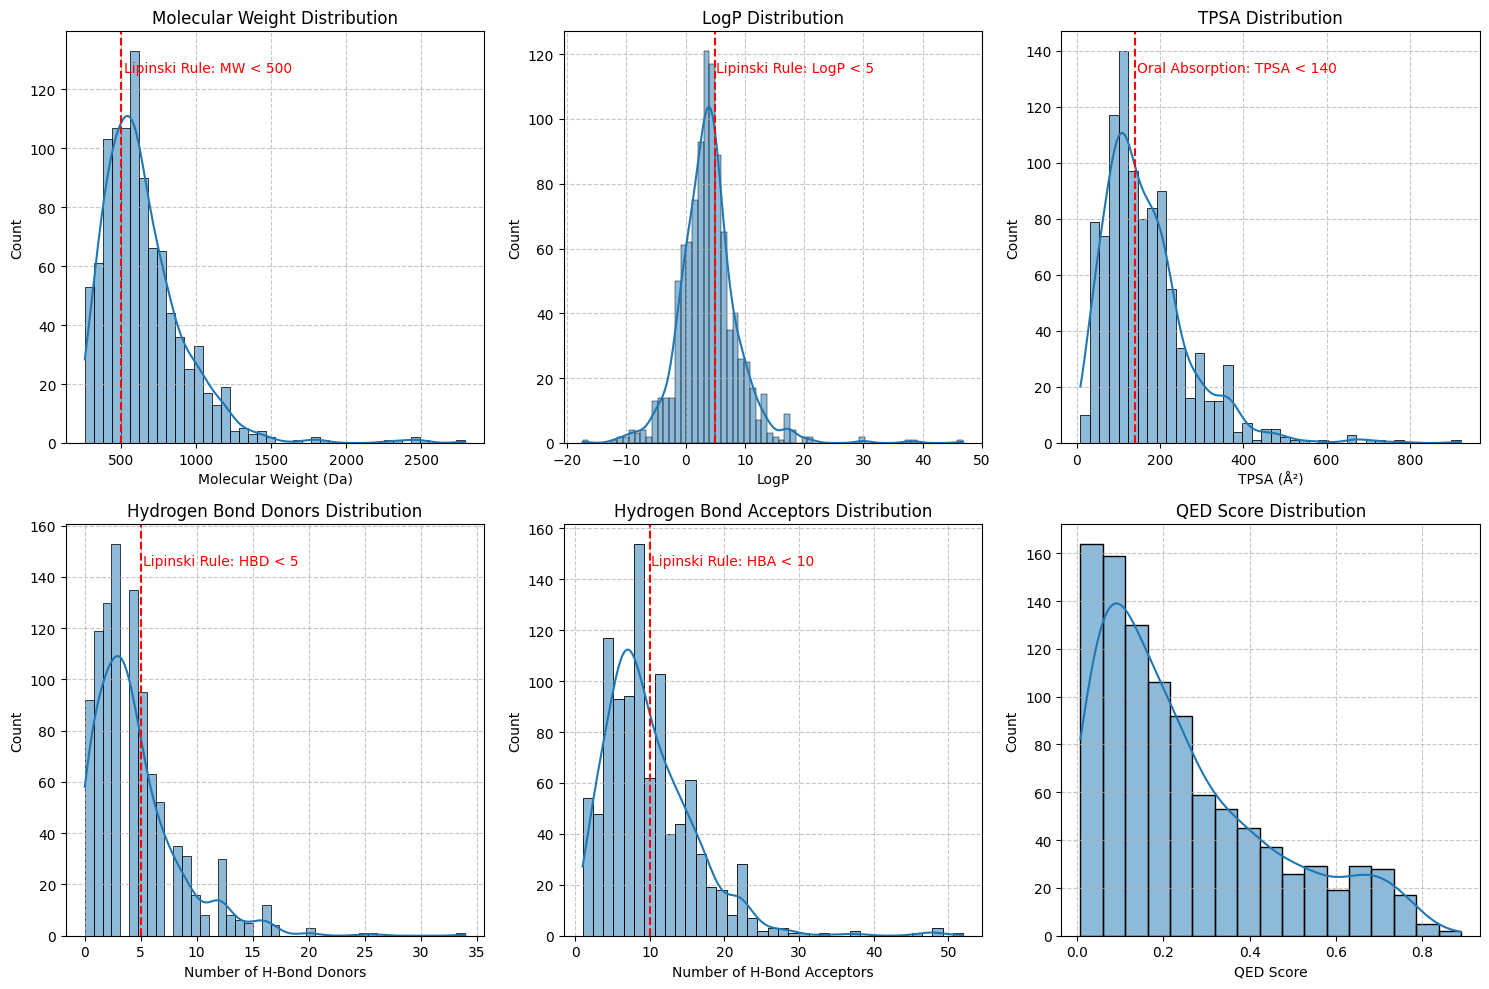


    # 물성 분포 그래프 설명:
    # 위 그래프들은 천연물 화합물들의 주요 물리화학적 특성 분포를 보여줍니다.
    #
    # 1. 분자량(Molecular Weight) 분포:
    #    - 리피스키 규칙: 500 Da 미만이 바람직함
    #    - 분자량이 작을수록 일반적으로 세포막 투과가 용이하고 생체이용률이 높아집니다.
    #
    # 2. LogP 분포:
    #    - 리피스키 규칙: 5 미만이 바람직함
    #    - LogP는 옥탄올/물 분배계수의 로그값으로, 분자의 지용성을 나타냅니다.
    #    - 적절한 LogP 값은 약물이 세포막을 통과하면서도 충분한 수용성을 가지게 합니다.
    #
    # 3. TPSA(Topological Polar Surface Area) 분포:
    #    - 140 Å² 미만이면 좋은 경구 흡수율을 가질 가능성이 높습니다.
    #    - TPSA는 분자의 극성 표면적으로, 세포막 투과성 및 생체이용률과 관련이 있습니다.
    #
    # 4. 수소 결합 공여체(HBD) 수 분포:
    #    - 리피스키 규칙: 5개 미만이 바람직함
    #    - 수소 결합 공여체는 -OH, -NH 등의 그룹으로, 분자의 수용성에 기여합니다.
    #
    # 5. 수소 결합 수용체(HBA) 수 분포:
    #    - 리피스키 규칙: 10개 미만이 바람직함
    #    - 수소 결합 수용체는 산소, 질소 원자 등으로, 분자의 수용성 및 단백질 결합에 기여합니다.
    #
    # 6. QED(Quantitative Estimate of Drug-likeness) 점수 분포:
    #    - 0(약물성 없음)부터 1(완벽한 약물성)까지의 값을 가집니다.
    #    - QED는 여러 물리화학적 특성을 종합하여 계산된 약물성 지표입니다.
    #    - 값이 높을수록 약물로서 개발 가능성이 높다고 볼 수 있습니다.
    #
    # 빨

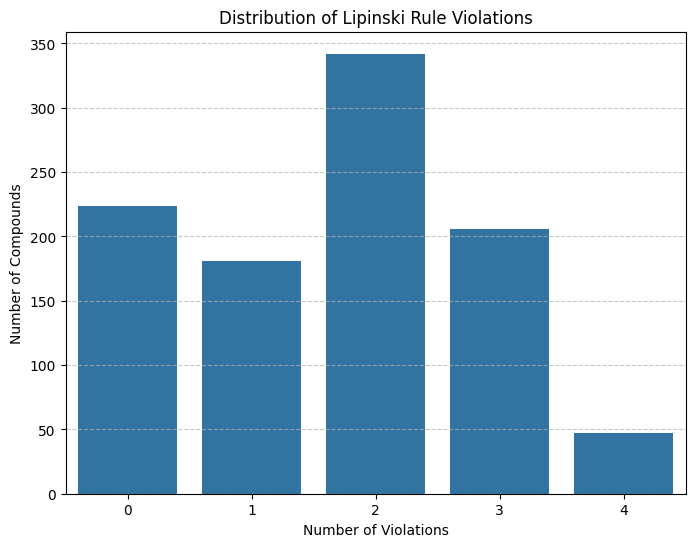


    # 리피스키 위반 개수 분포 그래프 설명:
    # 이 그래프는 천연물 화합물들이 리피스키의 약물성 규칙을 얼마나 많이 위반하는지 보여줍니다.
    #
    # 리피스키의 규칙(Lipinski's Rule of Five)은 경구 투여 약물의 성공 가능성을 예측하기 위한
    지침입니다.
    
물성 시각화 완료!
약물성 분자 필터링 중...
리피스키 규칙을 만족하는 약물성 분자: 183개
상위 10개 물성 분자 시각화 중...


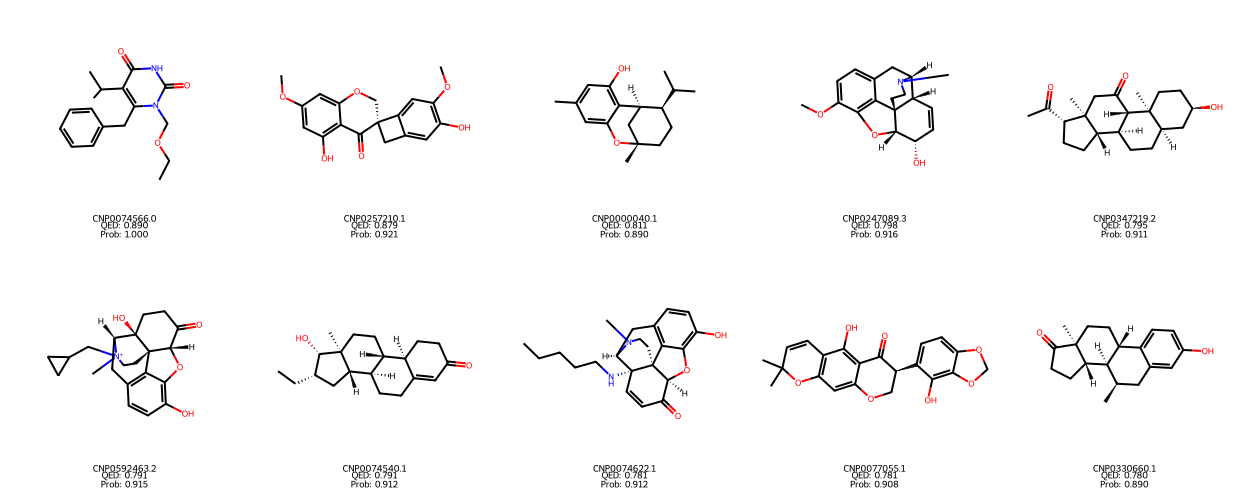

,COCONUT_ID,QED,MW,LogP,NumHDonors,NumHAcceptors,TPSA,Probability
6,CNP0074566.0,0.889815,302.374,2.24480,1,4,64.09,1.000000
432,CNP0257210.1,0.878837,328.320,2.18420,2,6,85.22,0.921431
828,CNP0000040.1,0.811044,260.377,4.39142,1,2,29.46,0.890336
483,CNP0247089.3,0.798144,299.370,1.50110,1,4,41.93,0.916380
544,CNP0347219.2,0.794959,332.484,3.77420,1,3,54.37,0.910710
498,CNP0592463.2,0.791390,356.442,1.67000,2,4,66.76,0.914641
532,CNP0074540.1,0.790670,302.458,4.12520,1,2,37.30,0.911806
525,CNP0074622.1,0.781267,368.477,2.30870,2,5,61.80,0.912206
571,CNP0077055.1,0.780804,382.368,3.36960,2,7,94.45,0.908239
834,CNP0330660.1,0.779658,284.399,4.06340,1,2,37.30,0.889957


물성 분자 시각화 완료!
스캐폴드 분석 중...
상위 10개 스캐폴드:
                                            Scaffold  Count
0    O=C1C=C2CC[C@@H]3[C@H](CCC4CCC[C@H]43)[C@H]2CC1      7
1       O=C1C=CC2C(=C1)CC[C@H]1[C@@H]3CCCC3CC[C@H]21      6
2                        O=c1cc(-c2ccccc2)oc2ccccc12      5
3         O=C1C=C2CC[C@H]3[C@@H]4CCCC4CC[C@@H]3C2CC1      5
4                         O=C1c2ccccc2C(=O)c2ccccc21      5
5    O=C1CCC2[C@@H](CC[C@H]3[C@@H]4CCCC4CC[C@H]23)C1      3
6  O=C1NCc2c1c1c3ccccc3n3c1c1c2c2ccccc2n1C1CCC[C@...      3
7     O=C1C=C2CC[C@H]3[C@@H]4CCC(=O)C4CC[C@@H]3C2CC1      3
8          O=C1CC[C@@H]2C1CC[C@@H]1c3ccccc3CC[C@H]12      3
9                             O=C1c2ccccc2Cc2ccccc21      2
총 화합물 수: 183
고유 스캐폴드 수: 141
스캐폴드 다양성: 0.770


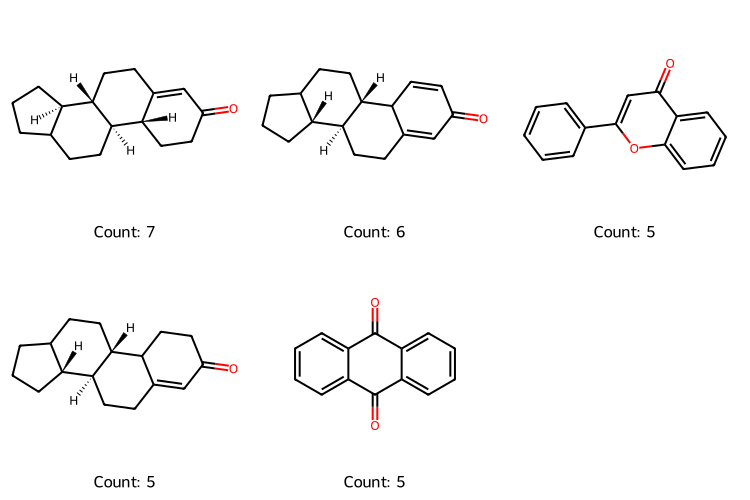

스캐폴드 분석 완료!
약물성 분자가 drug_like_compounds.csv에 저장되었습니다.

약물성 평가 파이프라인 완료!


In [ ]:
# 천연물 물성 예측
# RDKit을 활용한 천연물 분자 물성 예측

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# RDKit 관련 모듈
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, Lipinski, Crippen, MolSurf, QED
from rdkit.Chem.Scaffolds import MurckoScaffold

# PandasTools 대신 수동 분자 생성 함수 사용
def add_molecule_column(df, smiles_col='SMILES', mol_col='Molecule'):
    """SMILES 열에서 RDKit 분자 객체를 생성하여 새 열에 추가합니다."""
    df[mol_col] = [Chem.MolFromSmiles(smiles) if isinstance(smiles, str) else None
                  for smiles in df[smiles_col]]
    return df

# 이전 단계에서 예측된 활성 물질 로드
def load_predicted_actives(file_path="predicted_actives.csv"):
    print("예측된 활성 물질 로드 중...")

    # 파일 존재 여부 확인
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"예측된 활성 물질 파일을 찾을 수 없습니다: {file_path}")

    actives_data = pd.read_csv(file_path)

    # 상위 1000개 물질만 사용 (성능 향상을 위해)
    actives_data = actives_data.head(1000)

    # RDKit 분자 객체 생성 - 직접 구현
    actives_data = add_molecule_column(actives_data, 'SMILES', 'Molecule')

    # 유효한 분자만 필터링
    actives_data = actives_data[actives_data['Molecule'].notna()]

    print(f"로드된 활성 물질: {len(actives_data)}개")
    return actives_data

# 리피스키의 규칙 계산
def calculate_lipinski_params(dataframe):
    print("리피스키 규칙 매개변수 계산 중...")

    # 리피스키 규칙 매개변수 계산
    dataframe['MW'] = [Descriptors.MolWt(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
    dataframe['LogP'] = [Descriptors.MolLogP(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
    dataframe['NumHDonors'] = [Lipinski.NumHDonors(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
    dataframe['NumHAcceptors'] = [Lipinski.NumHAcceptors(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
    dataframe['NumRotatableBonds'] = [Descriptors.NumRotatableBonds(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
    dataframe['TPSA'] = [Descriptors.TPSA(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
    dataframe['NumRings'] = [Descriptors.RingCount(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]

    # 리피스키 규칙 위반 개수
    dataframe['Lipinski_Violations'] = (
        (dataframe['MW'] > 500).astype(int) +
        (dataframe['LogP'] > 5).astype(int) +
        (dataframe['NumHDonors'] > 5).astype(int) +
        (dataframe['NumHAcceptors'] > 10).astype(int)
    )

    # 약 유사성 (QED) 점수 계산
    dataframe['QED'] = [QED.qed(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]

    print("리피스키 규칙 계산 완료!")
    return dataframe

# 확장 물성 계산
def calculate_extended_properties(dataframe):
    print("확장 물성 계산 중...")

    # 용해도 관련 특성
    dataframe['MolLogP'] = [Crippen.MolLogP(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
    dataframe['MolMR'] = [Crippen.MolMR(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]

    # 프래그먼트 기반 물성
    dataframe['FractionCSP3'] = [Descriptors.FractionCSP3(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]
    dataframe['HeavyAtomCount'] = [mol.GetNumHeavyAtoms() if mol is not None else np.nan for mol in dataframe['Molecule']]

    # SA Score (합성 난이도) 계산 시도
    try:
        # SA Score 계산 함수 직접 구현
        def calculate_sa_score(mol):
            if mol is None:
                return np.nan

            # 간단한 대체 계산 방법:
            # 1. 고리 개수가 많을수록 복잡함
            ring_count = Descriptors.RingCount(mol)
            # 2. 키랄 중심이 많을수록 복잡함
            chiral_centers = len(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
            # 3. 원자 수가 많을수록 복잡함
            atom_count = mol.GetNumAtoms()

            # 간단한 점수 계산 (1-10 사이로 정규화)
            score = 1 + (ring_count * 0.5 + chiral_centers * 0.5 + atom_count * 0.01)
            return min(10, score)

        dataframe['SA_Score'] = [calculate_sa_score(mol) for mol in dataframe['Molecule']]
        print("SA Score 계산에 간단한 대체 방법을 사용했습니다.")
    except Exception as e:
        print(f"SA Score 계산 중 오류 발생: {e}")
        dataframe['SA_Score'] = np.nan

    # 추가 물리화학적 특성
    dataframe['LabuteASA'] = [Descriptors.LabuteASA(mol) if mol is not None else np.nan for mol in dataframe['Molecule']]

    # PEOE_VSA 계산 시 오류 방지
    try:
        # 개별적으로 계산하여 합산
        dataframe['PEOE_VSA'] = np.nan  # 기본값으로 설정

        for i, mol in enumerate(dataframe['Molecule']):
            if mol is not None:
                try:
                    peoe_sum = 0
                    for j in range(1, 4):  # PEOE_VSA1, PEOE_VSA2, PEOE_VSA3
                        desc_name = f"PEOE_VSA{j}"
                        if hasattr(Descriptors, desc_name):
                            desc_func = getattr(Descriptors, desc_name)
                            peoe_sum += desc_func(mol)
                    dataframe.at[i, 'PEOE_VSA'] = peoe_sum
                except:
                    pass  # 개별 분자 처리 중 오류 무시
    except Exception as e:
        print(f"PEOE_VSA 계산 중 오류: {e}")

    print("확장 물성 계산 완료!")
    return dataframe

# 물성 시각화
def visualize_properties(dataframe):
    print("물성 분포 시각화 중...")

    # 기본 물성 분포 시각화
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 분자량 분포
    sns.histplot(dataframe['MW'], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Molecular Weight Distribution')  # 분자량 분포
    axes[0, 0].set_xlabel('Molecular Weight (Da)')  # 분자량 (달톤)
    axes[0, 0].set_ylabel('Count')  # 개수
    axes[0, 0].axvline(x=500, color='r', linestyle='--')  # 리피스키 기준선
    axes[0, 0].grid(linestyle='--', alpha=0.7)
    axes[0, 0].text(520, axes[0, 0].get_ylim()[1]*0.9, 'Lipinski Rule: MW < 500', color='r')  # 텍스트 추가

    # LogP 분포
    sns.histplot(dataframe['LogP'], kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('LogP Distribution')  # LogP 분포
    axes[0, 1].set_xlabel('LogP')  # LogP
    axes[0, 1].set_ylabel('Count')  # 개수
    axes[0, 1].axvline(x=5, color='r', linestyle='--')  # 리피스키 기준선
    axes[0, 1].grid(linestyle='--', alpha=0.7)
    axes[0, 1].text(5.2, axes[0, 1].get_ylim()[1]*0.9, 'Lipinski Rule: LogP < 5', color='r')  # 텍스트 추가

    # TPSA 분포
    sns.histplot(dataframe['TPSA'], kde=True, ax=axes[0, 2])
    axes[0, 2].set_title('TPSA Distribution')  # TPSA 분포
    axes[0, 2].set_xlabel('TPSA (Å²)')  # TPSA (제곱옹스트롬)
    axes[0, 2].set_ylabel('Count')  # 개수
    axes[0, 2].axvline(x=140, color='r', linestyle='--')  # 경구 흡수 기준선
    axes[0, 2].grid(linestyle='--', alpha=0.7)
    axes[0, 2].text(145, axes[0, 2].get_ylim()[1]*0.9, 'Oral Absorption: TPSA < 140', color='r')  # 텍스트 추가

    # 수소 결합 공여체 분포
    sns.histplot(dataframe['NumHDonors'], kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Hydrogen Bond Donors Distribution')  # 수소 결합 공여체 수 분포
    axes[1, 0].set_xlabel('Number of H-Bond Donors')  # 수소 결합 공여체 수
    axes[1, 0].set_ylabel('Count')  # 개수
    axes[1, 0].axvline(x=5, color='r', linestyle='--')  # 리피스키 기준선
    axes[1, 0].grid(linestyle='--', alpha=0.7)
    axes[1, 0].text(5.2, axes[1, 0].get_ylim()[1]*0.9, 'Lipinski Rule: HBD < 5', color='r')  # 텍스트 추가

    # 수소 결합 수용체 분포
    sns.histplot(dataframe['NumHAcceptors'], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Hydrogen Bond Acceptors Distribution')  # 수소 결합 수용체 수 분포
    axes[1, 1].set_xlabel('Number of H-Bond Acceptors')  # 수소 결합 수용체 수
    axes[1, 1].set_ylabel('Count')  # 개수
    axes[1, 1].axvline(x=10, color='r', linestyle='--')  # 리피스키 기준선
    axes[1, 1].grid(linestyle='--', alpha=0.7)
    axes[1, 1].text(10.2, axes[1, 1].get_ylim()[1]*0.9, 'Lipinski Rule: HBA < 10', color='r')  # 텍스트 추가

    # QED 분포
    sns.histplot(dataframe['QED'], kde=True, ax=axes[1, 2])
    axes[1, 2].set_title('QED Score Distribution')  # 약 유사성(QED) 점수 분포
    axes[1, 2].set_xlabel('QED Score')  # QED 점수
    axes[1, 2].set_ylabel('Count')  # 개수
    axes[1, 2].grid(linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # 물성 분포 그래프 설명 추가
    print("""
    # 물성 분포 그래프 설명:
    # 위 그래프들은 천연물 화합물들의 주요 물리화학적 특성 분포를 보여줍니다.
    #
    # 1. 분자량(Molecular Weight) 분포:
    #    - 리피스키 규칙: 500 Da 미만이 바람직함
    #    - 분자량이 작을수록 일반적으로 세포막 투과가 용이하고 생체이용률이 높아집니다.
    #
    # 2. LogP 분포:
    #    - 리피스키 규칙: 5 미만이 바람직함
    #    - LogP는 옥탄올/물 분배계수의 로그값으로, 분자의 지용성을 나타냅니다.
    #    - 적절한 LogP 값은 약물이 세포막을 통과하면서도 충분한 수용성을 가지게 합니다.
    #
    # 3. TPSA(Topological Polar Surface Area) 분포:
    #    - 140 Å² 미만이면 좋은 경구 흡수율을 가질 가능성이 높습니다.
    #    - TPSA는 분자의 극성 표면적으로, 세포막 투과성 및 생체이용률과 관련이 있습니다.
    #
    # 4. 수소 결합 공여체(HBD) 수 분포:
    #    - 리피스키 규칙: 5개 미만이 바람직함
    #    - 수소 결합 공여체는 -OH, -NH 등의 그룹으로, 분자의 수용성에 기여합니다.
    #
    # 5. 수소 결합 수용체(HBA) 수 분포:
    #    - 리피스키 규칙: 10개 미만이 바람직함
    #    - 수소 결합 수용체는 산소, 질소 원자 등으로, 분자의 수용성 및 단백질 결합에 기여합니다.
    #
    # 6. QED(Quantitative Estimate of Drug-likeness) 점수 분포:
    #    - 0(약물성 없음)부터 1(완벽한 약물성)까지의 값을 가집니다.
    #    - QED는 여러 물리화학적 특성을 종합하여 계산된 약물성 지표입니다.
    #    - 값이 높을수록 약물로서 개발 가능성이 높다고 볼 수 있습니다.
    #
    # 빨간색 점선은 각 특성의 이상적인 기준값을 나타냅니다. 이 기준을 충족하는 화합물은
    # 경구 투여 약물로서 좋은 흡수율과 생체이용률을 가질 가능성이 높습니다.
    """)

    # 리피스키 위반 개수 분포
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Lipinski_Violations', data=dataframe)
    plt.title('Distribution of Lipinski Rule Violations')  # 리피스키 규칙 위반 개수 분포
    plt.xlabel('Number of Violations')  # 위반 개수
    plt.ylabel('Number of Compounds')  # 화합물 수
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # 리피스키 위반 개수 분포 설명
    print('''
    # 리피스키 위반 개수 분포 그래프 설명:
    # 이 그래프는 천연물 화합물들이 리피스키의 약물성 규칙을 얼마나 많이 위반하는지 보여줍니다.
    #
    # 리피스키의 규칙(Lipinski's Rule of Five)은 경구 투여 약물의 성공 가능성을 예측하기 위한
    지침입니다.
    ''')
    print("물성 시각화 완료!")

# 약물성 필터링
def filter_drug_like_compounds(dataframe):
    print("약물성 분자 필터링 중...")

    # 약물성 필터 조건
    drug_like = (
        (dataframe['MW'] <= 500) &
        (dataframe['LogP'] <= 5) &
        (dataframe['NumHDonors'] <= 5) &
        (dataframe['NumHAcceptors'] <= 10) &
        (dataframe['NumRotatableBonds'] <= 10) &
        (dataframe['TPSA'] <= 140)
    )

    # 약물성 필터 적용
    drug_like_compounds = dataframe[drug_like].copy()

    # QED 점수로 정렬
    drug_like_compounds = drug_like_compounds.sort_values('QED', ascending=False)

    print(f"리피스키 규칙을 만족하는 약물성 분자: {len(drug_like_compounds)}개")
    return drug_like_compounds

# 상위 물성 분자 시각화
def visualize_top_compounds(dataframe, n=10):
    print(f"상위 {n}개 물성 분자 시각화 중...")

    # 데이터가 충분한지 확인
    if len(dataframe) < n:
        n = len(dataframe)
        print(f"경고: 데이터가 {n}개만 있어서 {n}개만 표시합니다.")

    if len(dataframe) == 0:
        print("경고: 표시할 화합물이 없습니다.")
        return

    # QED 기준 상위 물질
    top_qed = dataframe.nlargest(n, 'QED')

    # 분자 이미지 생성
    top_mols = top_qed['Molecule'].tolist()

    # COCONUT_ID가 있는지 확인
    if 'COCONUT_ID' in top_qed.columns:
        top_ids = top_qed['COCONUT_ID'].tolist()
    else:
        # 인덱스 사용
        top_ids = [f"Compound_{i+1}" for i in range(len(top_mols))]

    top_qeds = top_qed['QED'].tolist()

    # Probability가 있는지 확인
    if 'Probability' in top_qed.columns:
        top_probs = top_qed['Probability'].tolist()
        legends = [f"{idx}\nQED: {qed:.3f}\nProb: {prob:.3f}"
                  for idx, qed, prob in zip(top_ids, top_qeds, top_probs)]
    else:
        legends = [f"{idx}\nQED: {qed:.3f}"
                  for idx, qed in zip(top_ids, top_qeds)]

    # 이미지 생성
    try:
        img = Draw.MolsToGridImage(top_mols, molsPerRow=5, subImgSize=(250, 250), legends=legends)
        display(img)
    except Exception as e:
        print(f"분자 시각화 중 오류 발생: {e}")
        # 개별 분자 시각화 시도
        try:
            for i, mol in enumerate(top_mols[:min(5, len(top_mols))]):
                if mol is not None:
                    display(Draw.MolToImage(mol, size=(250, 250), legend=legends[i]))
        except:
            print("개별 분자 시각화도 실패했습니다.")

    # 물성 데이터 표시 - 존재하는 컬럼만 선택
    display_cols = ['QED', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']
    if 'Probability' in top_qed.columns:
        display_cols.append('Probability')
    if 'COCONUT_ID' in top_qed.columns:
        display_cols = ['COCONUT_ID'] + display_cols

    display_cols = [col for col in display_cols if col in top_qed.columns]

    display(top_qed[display_cols])

    print("물성 분자 시각화 완료!")

# 스캐폴드 분석
def analyze_scaffolds(dataframe):
    print("스캐폴드 분석 중...")

    # 카운터 변수 - 오류 없이 처리된 분자 수 계산
    successful_scaffolds = 0

    # Murcko 스캐폴드 추출 - 각 분자별 오류 처리
    scaffolds = []
    for mol in dataframe['Molecule']:
        try:
            if mol is not None:
                scaffold = MurckoScaffold.GetScaffoldForMol(mol)
                if scaffold is not None and scaffold.GetNumAtoms() > 0:
                    scaffolds.append(Chem.MolToSmiles(scaffold))
                    successful_scaffolds += 1
                else:
                    scaffolds.append("")
            else:
                scaffolds.append("")
        except Exception as e:
            scaffolds.append("")

    dataframe['Scaffold'] = scaffolds

    # 빈 스캐폴드 제거
    scaffold_df = dataframe[dataframe['Scaffold'] != ""].copy()

    # 스캐폴드 분석 가능 여부 확인
    if successful_scaffolds == 0:
        print("유효한 스캐폴드가 생성되지 않았습니다.")
        return pd.DataFrame(columns=['Scaffold', 'Count'])

    # 스캐폴드 빈도 계산
    scaffold_counts = scaffold_df['Scaffold'].value_counts().reset_index()
    scaffold_counts.columns = ['Scaffold', 'Count']

    # 상위 10개 스캐폴드 출력
    top_n = min(10, len(scaffold_counts))
    print(f"상위 {top_n}개 스캐폴드:")
    print(scaffold_counts.head(top_n))

    # 스캐폴드 다양성 계산
    total_compounds = len(scaffold_df)
    total_scaffolds = len(scaffold_counts)

    if total_compounds > 0:
        scaffold_diversity = total_scaffolds / total_compounds
        print(f"총 화합물 수: {total_compounds}")
        print(f"고유 스캐폴드 수: {total_scaffolds}")
        print(f"스캐폴드 다양성: {scaffold_diversity:.3f}")
    else:
        print("분석할 화합물이 없습니다.")
        return scaffold_counts

    # 상위 스캐폴드 시각화
    if len(scaffold_counts) >= 5:
        top_scaffolds = scaffold_counts.head(5)

        try:
            # 스캐폴드 SMILES로 분자 생성
            top_scaffold_mols = []
            valid_indices = []
            valid_counts = []

            for i, (scaffold_smiles, count) in enumerate(zip(top_scaffolds['Scaffold'], top_scaffolds['Count'])):
                mol = Chem.MolFromSmiles(scaffold_smiles)
                if mol is not None:
                    top_scaffold_mols.append(mol)
                    valid_indices.append(i)
                    valid_counts.append(count)

            if len(top_scaffold_mols) > 0:
                img = Draw.MolsToGridImage(top_scaffold_mols, molsPerRow=3, subImgSize=(250, 250),
                                          legends=[f"Count: {count}" for count in valid_counts])
                display(img)
            else:
                print("유효한 스캐폴드 분자가 없어 시각화를 건너뜁니다.")
        except Exception as e:
            print(f"스캐폴드 시각화 중 오류 발생: {e}")
    else:
        print(f"시각화를 위한 충분한 스캐폴드가 없습니다. (필요: 5, 현재: {len(scaffold_counts)})")

    print("스캐폴드 분석 완료!")
    return scaffold_counts

# 결과 저장
def save_property_results(dataframe, output_file="drug_like_compounds.csv"):
    # 필요한 칼럼 선택
    essential_cols = [
        'COCONUT_ID', 'SMILES', 'Target', 'Probability',
        'MW', 'LogP', 'NumHDonors', 'NumHAcceptors',
        'NumRotatableBonds', 'TPSA', 'QED', 'Lipinski_Violations'
    ]

    # 유효한 칼럼만 선택
    save_cols = [col for col in essential_cols if col in dataframe.columns]

    if len(save_cols) == 0:
        print("경고: 저장할 컬럼이 없습니다.")
        return dataframe

    # 결과 저장
    try:
        dataframe[save_cols].to_csv(output_file, index=False)
        print(f"약물성 분자가 {output_file}에 저장되었습니다.")
    except Exception as e:
        print(f"결과 저장 중 오류 발생: {e}")

    return dataframe[save_cols]

# 전체 파이프라인 실행
def run_property_pipeline(active_file_path="predicted_actives.csv",
                         output_file='drug_like_compounds.csv'):
    try:
        print("약물성 평가 파이프라인 시작...")

        # 예측된 활성 물질 로드
        actives_data = load_predicted_actives(active_file_path)

        # 리피스키 매개변수 계산
        actives_with_lipinski = calculate_lipinski_params(actives_data)

        # 확장 물성 계산 (오류 처리 추가)
        try:
            actives_with_properties = calculate_extended_properties(actives_with_lipinski)
        except Exception as e:
            print(f"확장 물성 계산 중 오류 발생: {e}")
            print("기본 물성만 사용하여 계속 진행합니다.")
            actives_with_properties = actives_with_lipinski

        # 물성 시각화
        try:
            visualize_properties(actives_with_properties)
        except Exception as e:
            print(f"물성 시각화 중 오류 발생: {e}")

        # 약물성 필터링
        drug_like_compounds = filter_drug_like_compounds(actives_with_properties)

        # 상위 물성 분자 시각화
        try:
            visualize_top_compounds(drug_like_compounds)
        except Exception as e:
            print(f"상위 물성 분자 시각화 중 오류 발생: {e}")

        # 스캐폴드 분석
        try:
            scaffold_counts = analyze_scaffolds(drug_like_compounds)
        except Exception as e:
            print(f"스캐폴드 분석 중 오류 발생: {e}")
            scaffold_counts = pd.DataFrame(columns=['Scaffold', 'Count'])

        # 결과 저장
        result_df = save_property_results(drug_like_compounds, output_file)

        print("\n약물성 평가 파이프라인 완료!")
        return drug_like_compounds, scaffold_counts

    except Exception as e:
        print(f"파이프라인 실행 중 오류 발생: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame(), pd.DataFrame()

# 메인 실행
if __name__ == "__main__":
    drug_like_compounds, scaffold_counts = run_property_pipeline()

# 천연물 ADMET 예측

Loading file: predicted_actives.csv
Original data size: 10000
Data size after removing duplicates: 10000
Number of valid SMILES: 10000
Predicting ADMET properties for 10000 active compounds.

1. Calculating basic molecular properties using RDKit...


Found local copy...
Loading...
Done!



2. Evaluating druglikeness...

3. Making predictions using ADMET-AI...
ADMET-AI package is not installed. Please install it with 'pip install admet-ai'.

4. Making predictions using TDC datasets...
Making predictions for Caco2_Wang dataset...


Found local copy...
Loading...
Done!


Making predictions for HIA_Hou dataset...


Found local copy...
Loading...
Done!


Making predictions for Pgp_Broccatelli dataset...


Found local copy...
Loading...
Done!


Making predictions for BBB_Martins dataset...


[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not removing hydrogen atom without neighbors
[01:59:00] WARNING: not r

Making predictions for CYP3A4_Veith dataset...


Found local copy...
Loading...
Done!


Making predictions for CYP2D6_Veith dataset...


Found local copy...
Loading...
Done!


Making predictions for Half_Life_Obach dataset...


Found local copy...
Loading...
Done!


Making predictions for Clearance_Hepatocyte_AZ dataset...


['lipophilicity_astrazeneca', 'solubility_aqsoldb', 'hydrationfreeenergy_freesolv', 'caco2_wang', 'pampa_ncats', 'approved_pampa_ncats', 'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'vdss_lombardo', 'cyp2c19_veith', 'cyp2d6_veith', 'cyp3a4_veith', 'cyp1a2_veith', 'cyp2c9_veith', 'cyp2c9_substrate_carbonmangels', 'cyp2d6_substrate_carbonmangels', 'cyp3a4_substrate_carbonmangels', 'bbb_martins', 'b3db_classification', 'b3db_regression', 'ppbr_az', 'half_life_obach', 'clearance_hepatocyte_az', 'clearance_microsome_az', 'hlm', 'rlm']
['lipophilicity_astrazeneca', 'solubility_aqsoldb', 'hydrationfreeenergy_freesolv', 'caco2_wang', 'pampa_ncats', 'approved_pampa_ncats', 'hia_hou', 'pgp_broccatelli', 'bioavailability_ma', 'vdss_lombardo', 'cyp2c19_veith', 'cyp2d6_veith', 'cyp3a4_veith', 'cyp1a2_veith', 'cyp2c9_veith', 'cyp2c9_substrate_carbonmangels', 'cyp2d6_substrate_carbonmangels', 'cyp3a4_substrate_carbonmangels', 'bbb_martins', 'b3db_classification', 'b3db_regression', 'ppbr_az', 

Making predictions for LD50_Zhu dataset...
Error processing LD50_Zhu: ('ld50_zhu', 'does not match to available values. Please double check.')
Making predictions for hERG_Karim dataset...
Error processing hERG_Karim: ('herg_karim', 'does not match to available values. Please double check.')

5. Integrating results and creating visualizations...


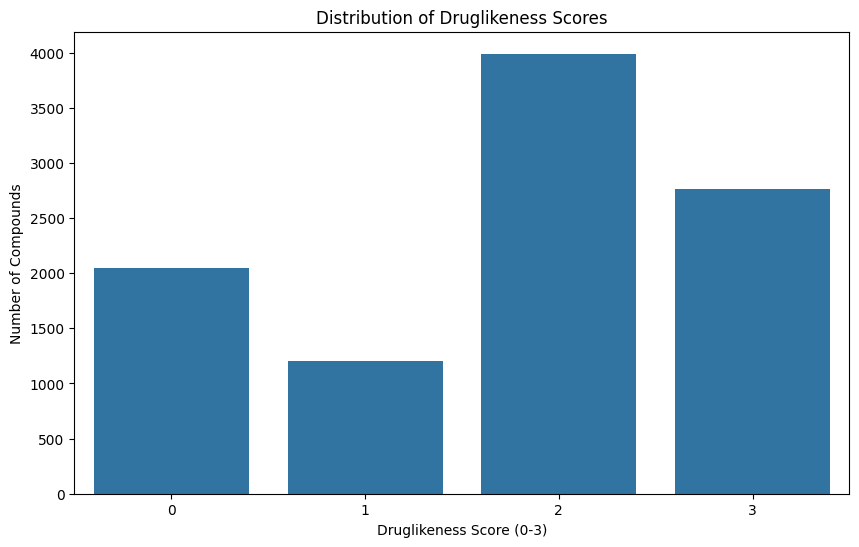

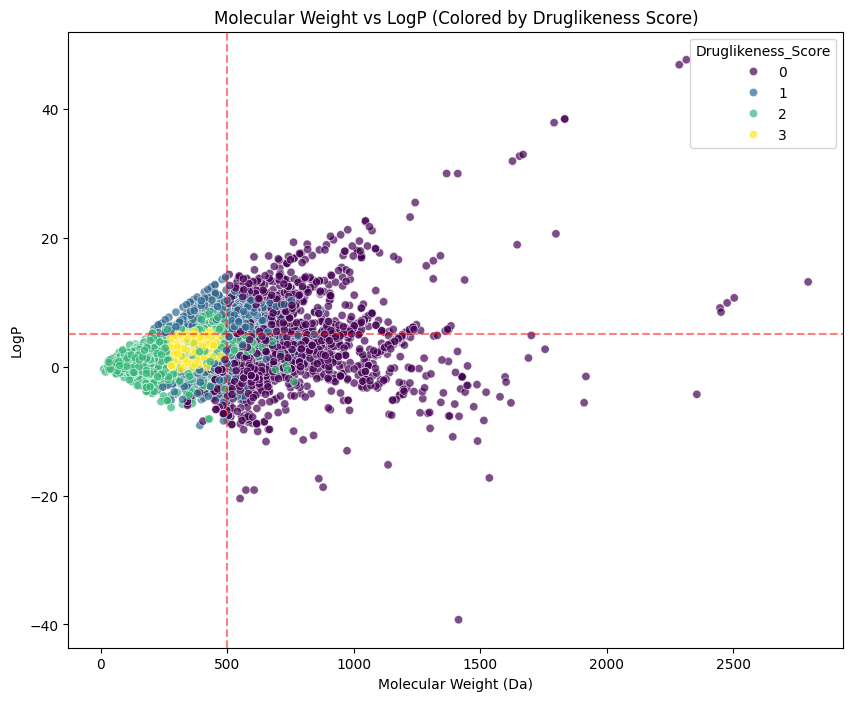

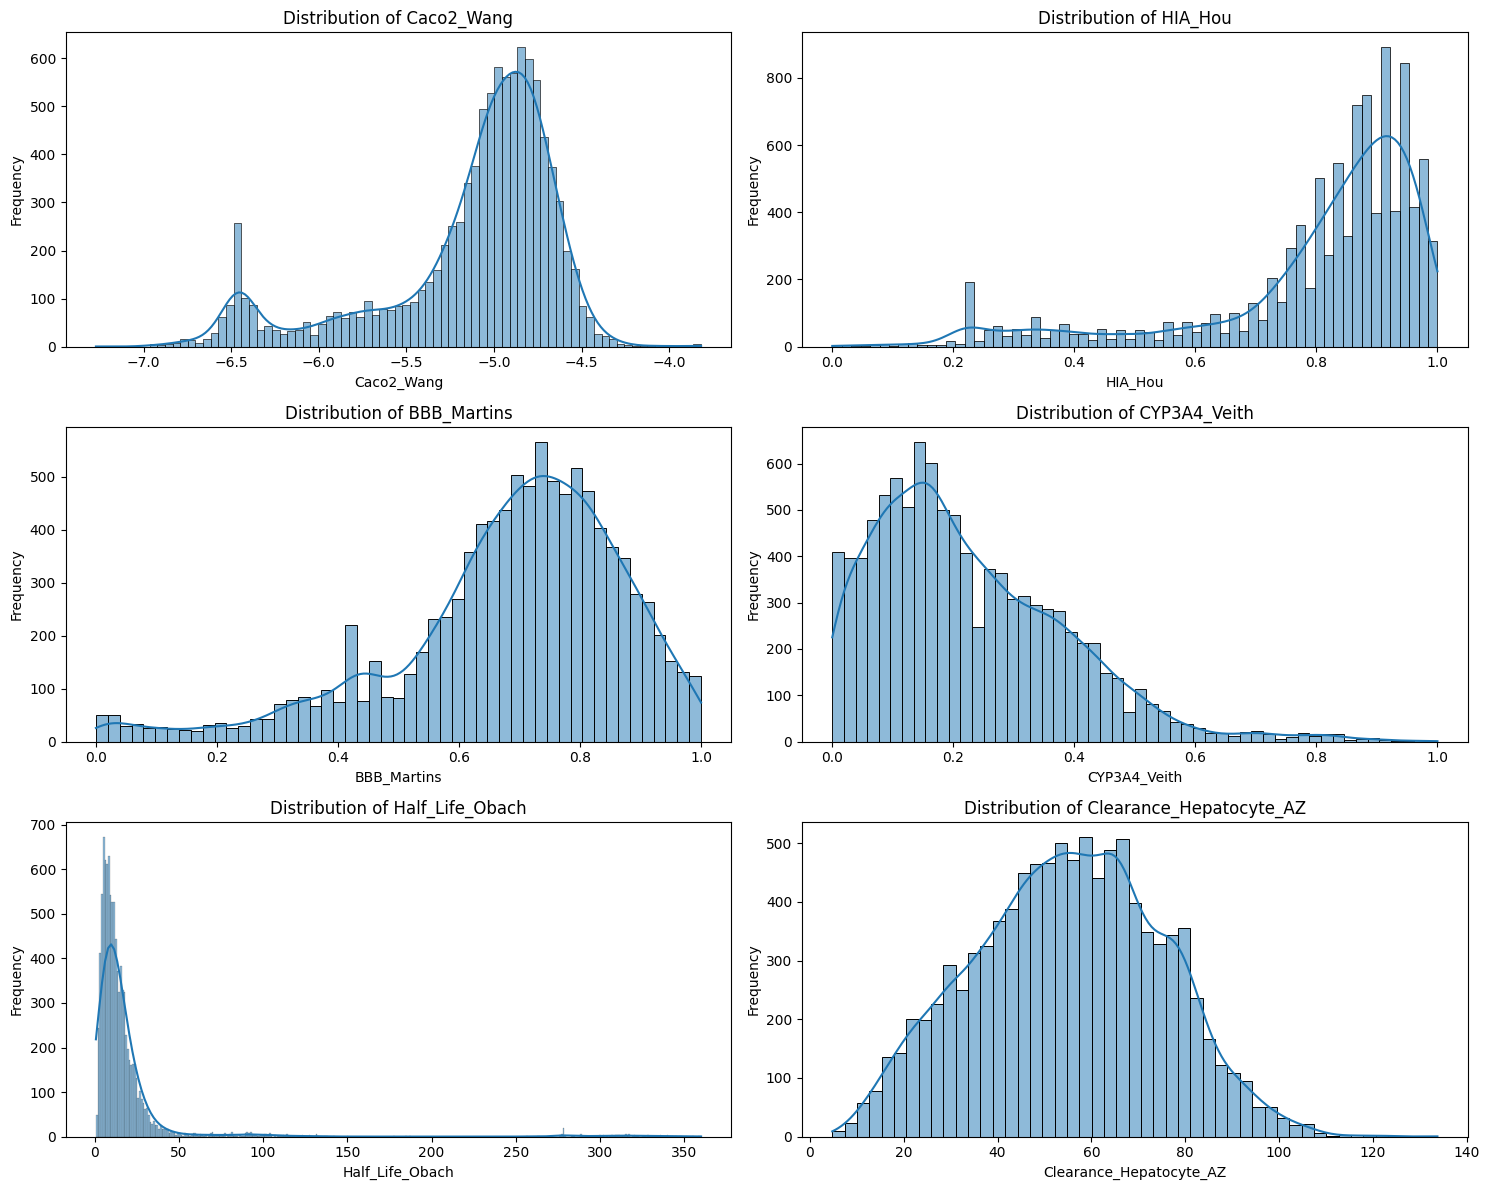

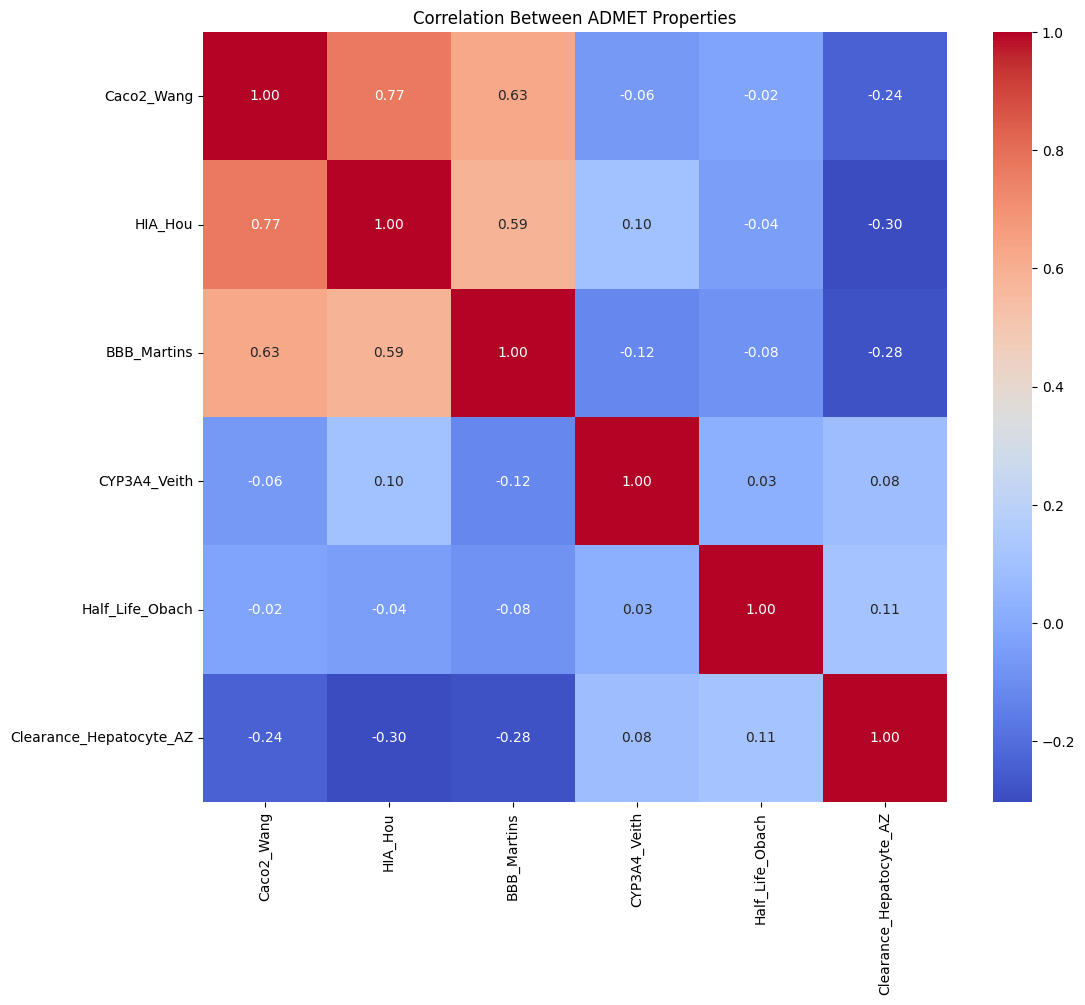


Saving results to predicted_actives_admet.csv...
Results saved to predicted_actives_admet.csv.

Prediction Results Summary:
ADMET properties predicted for 10000 compounds.

Druglikeness Score Distribution:
  Score 0: 2049 compounds (20.5%)
  Score 1: 1201 compounds (12.0%)
  Score 2: 3990 compounds (39.9%)
  Score 3: 2760 compounds (27.6%)

Lipinski Rule Violations Distribution:
  0 violations: 5570 compounds (55.7%)
  1 violations: 1790 compounds (17.9%)
  2 violations: 1703 compounds (17.0%)
  3 violations: 792 compounds (7.9%)
  4 violations: 145 compounds (1.5%)

Major ADMET Properties Statistics:
  Caco2_Wang: Mean = -5.138, Median = -4.984, Std Dev = 0.522
  HIA_Hou: Mean = 0.801, Median = 0.860, Std Dev = 0.192
  BBB_Martins: Mean = 0.682, Median = 0.718, Std Dev = 0.195
  CYP3A4_Veith: Mean = 0.226, Median = 0.190, Std Dev = 0.160


In [ ]:
# 필요한 라이브러리 설치
!pip install PyTDC pandas numpy matplotlib seaborn scikit-learn rdkit-pypi admet-ai

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Lipinski
import warnings
warnings.filterwarnings('ignore')

# 1. 활성 화합물 데이터 로드
def load_active_compounds(file_path, smiles_column='SMILES'):
    """Load active compounds data from a file"""
    try:
        # Load CSV file
        df = pd.read_csv(file_path)

        # Check if SMILES column exists
        if smiles_column not in df.columns:
            # Find other possible SMILES column names
            possible_smiles_columns = ['smiles', 'SMILES', 'Smiles', 'structure', 'Structure', 'canonical_smiles']
            for col in possible_smiles_columns:
                if col in df.columns:
                    smiles_column = col
                    break
            else:
                print(f"Could not find SMILES column in file. First 5 column names: {list(df.columns[:5])}")
                return None, None

        # Remove duplicates and keep only valid SMILES
        print(f"Original data size: {len(df)}")
        df = df.drop_duplicates(subset=[smiles_column])
        print(f"Data size after removing duplicates: {len(df)}")

        valid_smiles = []
        for smiles in df[smiles_column]:
            if isinstance(smiles, str):
                mol = Chem.MolFromSmiles(smiles)
                if mol is not None:
                    valid_smiles.append(smiles)

        print(f"Number of valid SMILES: {len(valid_smiles)}")
        return valid_smiles, df

    except Exception as e:
        print(f"Error loading file: {str(e)}")
        return None, None

# 2. RDKit을 사용한 기본 분자 속성 계산
def calculate_molecular_properties(smiles_list):
    """Calculate basic physicochemical properties of molecules using RDKit"""
    properties = []
    valid_smiles = []

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Calculate basic physicochemical properties
            props = {
                'SMILES': smiles,
                'MW': Descriptors.MolWt(mol),
                'LogP': Descriptors.MolLogP(mol),
                'HBA': Descriptors.NumHAcceptors(mol),
                'HBD': Descriptors.NumHDonors(mol),
                'TPSA': Descriptors.TPSA(mol),
                'RotBonds': Descriptors.NumRotatableBonds(mol),
                'AromaticRings': Chem.Lipinski.NumAromaticRings(mol),
                'HeavyAtoms': Chem.Lipinski.HeavyAtomCount(mol)
            }
            properties.append(props)
            valid_smiles.append(smiles)

    if properties:
        return pd.DataFrame(properties)
    else:
        print("No valid SMILES found.")
        return None

# 3. Lipinski의 Rule of Five 및 다른 약물성 규칙 평가
def evaluate_druglikeness(df_properties):
    """Evaluate druglikeness of molecules"""
    if df_properties is None:
        return None

    # Calculate Lipinski's Rule of Five violations
    df_properties['Lipinski_Violations'] = 0

    # Molecular weight > 500
    df_properties.loc[df_properties['MW'] > 500, 'Lipinski_Violations'] += 1

    # LogP > 5
    df_properties.loc[df_properties['LogP'] > 5, 'Lipinski_Violations'] += 1

    # Hydrogen bond acceptors > 10
    df_properties.loc[df_properties['HBA'] > 10, 'Lipinski_Violations'] += 1

    # Hydrogen bond donors > 5
    df_properties.loc[df_properties['HBD'] > 5, 'Lipinski_Violations'] += 1

    # Veber rule (TPSA <= 140 and rotatable bonds <= 10)
    df_properties['Veber_Compliant'] = (
        (df_properties['TPSA'] <= 140) &
        (df_properties['RotBonds'] <= 10)
    )

    # Ghose rule
    df_properties['Ghose_Compliant'] = (
        (df_properties['MW'] >= 160) & (df_properties['MW'] <= 480) &
        (df_properties['LogP'] >= -0.4) & (df_properties['LogP'] <= 5.6) &
        (df_properties['HeavyAtoms'] >= 20) & (df_properties['HeavyAtoms'] <= 70)
    )

    # Druglikeness score (0-3)
    df_properties['Druglikeness_Score'] = (
        (df_properties['Lipinski_Violations'] <= 1).astype(int) +
        df_properties['Veber_Compliant'].astype(int) +
        df_properties['Ghose_Compliant'].astype(int)
    )

    return df_properties

# 4. ADMET-AI를 사용한 ADMET 속성 예측 -추후에 설치하여 사용^^
def predict_admet_properties_with_admet_ai(smiles_list):
    """Predict ADMET properties of molecules using ADMET-AI"""
    try:
        from admet_ai import predict_admet

        # Batch processing for large datasets
        batch_size = 100
        results = []

        for i in range(0, len(smiles_list), batch_size):
            batch_smiles = smiles_list[i:i+batch_size]
            print(f"Processing batch: {i+1}-{min(i+batch_size, len(smiles_list))}/{len(smiles_list)}")
            batch_results = predict_admet(batch_smiles)
            results.extend(batch_results)

        # Convert results to DataFrame
        df_results = pd.DataFrame()
        df_results['SMILES'] = smiles_list

        # Extract all properties for all molecules
        for prop in results[0].keys():
            df_results[prop] = [result[prop] for result in results]

        return df_results

    except ImportError:
        print("ADMET-AI package is not installed. Please install it with 'pip install admet-ai'.")
        return None

# 5. TDC 데이터셋에서 ADMET 속성 예측
def predict_admet_with_tdc(smiles_list):
    """Predict ADMET properties using TDC datasets"""
    try:
        from tdc.single_pred import ADME
        from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

        # List of major ADMET datasets
        dataset_names = [
            'Caco2_Wang',        # Absorption
            'HIA_Hou',           # Absorption
            'Pgp_Broccatelli',   # Distribution
            'BBB_Martins',       # Distribution
            'CYP3A4_Veith',      # Metabolism
            'CYP2D6_Veith',      # Metabolism
            'Half_Life_Obach',   # Excretion
            'Clearance_Hepatocyte_AZ',  # Excretion
            'LD50_Zhu',          # Toxicity
            'hERG_Karim'         # Toxicity
        ]

        # List of classification datasets
        classification_datasets = [
            'HIA_Hou', 'Pgp_Broccatelli', 'BBB_Martins',
            'CYP3A4_Veith', 'CYP2D6_Veith'
        ]

        # Function to extract molecular features
        def extract_features(smiles_list):
            features = []
            valid_smiles = []

            for smiles in smiles_list:
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    # Calculate Morgan fingerprints (ECFP)
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
                    features.append(list(fp))
                    valid_smiles.append(smiles)

            return np.array(features), valid_smiles

        # DataFrame to store results
        results_df = pd.DataFrame({'SMILES': smiles_list})

        # Make predictions for each dataset
        for dataset_name in dataset_names:
            print(f"Making predictions for {dataset_name} dataset...")

            try:
                # Load dataset
                data = ADME(name=dataset_name)
                df = data.get_data()

                # Check if classification or regression
                is_classification = dataset_name in classification_datasets

                # Extract features for training data
                X_train, valid_train_smiles = extract_features(df['Drug'])
                y_train = df.loc[df['Drug'].isin(valid_train_smiles), 'Y'].values

                # Select and train model
                if is_classification:
                    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
                else:
                    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

                model.fit(X_train, y_train)

                # Extract features for test molecules
                X_test, valid_test_smiles = extract_features(smiles_list)

                # Make predictions
                if is_classification and hasattr(model, 'predict_proba'):
                    y_pred = model.predict_proba(X_test)[:, 1]
                else:
                    y_pred = model.predict(X_test)

                # Store results
                temp_df = pd.DataFrame({
                    'SMILES': valid_test_smiles,
                    dataset_name: y_pred
                })

                # Merge results
                results_df = pd.merge(results_df, temp_df, on='SMILES', how='left')

            except Exception as e:
                print(f"Error processing {dataset_name}: {str(e)}")
                continue

        return results_df

    except ImportError:
        print("TDC package is not installed. Please install it with 'pip install PyTDC'.")
        return None

# 6. 결과 통합 및 시각화 (영문 그래프 적용)
def integrate_and_visualize_results(admet_ai_results, rdkit_properties, tdc_results, original_df):
    """Integrate all prediction results and visualize them"""
    # Integrate results
    all_results = rdkit_properties.copy() if rdkit_properties is not None else pd.DataFrame()

    # Merge ADMET-AI results
    if admet_ai_results is not None and not all_results.empty:
        all_results = pd.merge(all_results, admet_ai_results, on='SMILES', how='outer')
    elif admet_ai_results is not None:
        all_results = admet_ai_results

    # Merge TDC results
    if tdc_results is not None and not all_results.empty:
        all_results = pd.merge(all_results, tdc_results, on='SMILES', how='outer')
    elif tdc_results is not None:
        all_results = tdc_results

    # Merge with original data (to keep additional information)
    if original_df is not None and not all_results.empty:
        # Find SMILES column in original data
        smiles_col = None
        for col in ['SMILES', 'smiles', 'Smiles', 'structure', 'Structure', 'canonical_smiles']:
            if col in original_df.columns:
                smiles_col = col
                break

        if smiles_col:
            # Select all columns from original data except SMILES column
            original_cols = [col for col in original_df.columns if col != smiles_col]

            # Merge original data with results
            merged_results = pd.merge(all_results, original_df, left_on='SMILES', right_on=smiles_col, how='left')

            # Remove duplicate columns
            all_results = merged_results

    if all_results.empty:
        print("No results to integrate.")
        return None

    # Visualize results
    # 1. Druglikeness distribution
    if 'Druglikeness_Score' in all_results.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Druglikeness_Score', data=all_results)
        plt.title('Distribution of Druglikeness Scores')
        plt.xlabel('Druglikeness Score (0-3)')
        plt.ylabel('Number of Compounds')
        plt.savefig('druglikeness_score_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

    # 2. Molecular weight vs LogP scatter plot (colored by druglikeness score)
    if ('Druglikeness_Score' in all_results.columns and
        'MW' in all_results.columns and
        'LogP' in all_results.columns):
        plt.figure(figsize=(10, 8))
        scatter = sns.scatterplot(x='MW', y='LogP', hue='Druglikeness_Score',
                                  palette='viridis', data=all_results, alpha=0.7)
        plt.axhline(y=5, color='r', linestyle='--', alpha=0.5)  # LogP = 5 reference line
        plt.axvline(x=500, color='r', linestyle='--', alpha=0.5)  # MW = 500 reference line
        plt.title('Molecular Weight vs LogP (Colored by Druglikeness Score)')
        plt.xlabel('Molecular Weight (Da)')
        plt.ylabel('LogP')
        plt.savefig('mw_vs_logp.png', dpi=300, bbox_inches='tight')
        plt.show()

    # 3. Distribution of major ADMET properties
    admet_columns = [col for col in all_results.columns if col not in ['SMILES', 'MW', 'LogP', 'HBA', 'HBD', 'TPSA',
                                                                     'RotBonds', 'AromaticRings', 'HeavyAtoms',
                                                                     'Lipinski_Violations', 'Veber_Compliant',
                                                                     'Ghose_Compliant', 'Druglikeness_Score']]

    # Exclude columns from original data
    if original_df is not None:
        admet_columns = [col for col in admet_columns if col not in original_df.columns]

    # Select only major ADMET properties (max 10)
    key_admet_props = ['Caco2_Wang', 'HIA_Hou', 'BBB_Martins', 'CYP3A4_Veith',
                       'Half_Life_Obach', 'Clearance_Hepatocyte_AZ', 'LD50_Zhu', 'hERG_Karim']

    selected_admet_columns = [col for col in key_admet_props if col in admet_columns]
    if not selected_admet_columns:
        selected_admet_columns = admet_columns[:min(10, len(admet_columns))]

    if selected_admet_columns:
        # Draw histograms
        n_cols = 2
        n_rows = (len(selected_admet_columns) + n_cols - 1) // n_cols

        plt.figure(figsize=(15, n_rows * 4))

        for i, col in enumerate(selected_admet_columns):
            plt.subplot(n_rows, n_cols, i + 1)
            sns.histplot(all_results[col].dropna(), kde=True)
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')

        plt.tight_layout()
        plt.savefig('admet_properties_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

    # 4. Correlation heatmap (between ADMET properties)
    if len(selected_admet_columns) > 1:
        plt.figure(figsize=(12, 10))
        correlation_matrix = all_results[selected_admet_columns].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Between ADMET Properties')
        plt.savefig('admet_correlation_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()

    return all_results

# 메인 함수
def predict_admet_for_active_compounds(file_path, output_file=None):
    """Main function to predict ADMET properties for active compounds"""
    print(f"Loading file: {file_path}")
    smiles_list, original_df = load_active_compounds(file_path)

    if smiles_list is None:
        return None

    print(f"Predicting ADMET properties for {len(smiles_list)} active compounds.")

    # 1. Calculate basic molecular properties using RDKit
    print("\n1. Calculating basic molecular properties using RDKit...")
    rdkit_properties = calculate_molecular_properties(smiles_list)

    # 2. Evaluate druglikeness
    print("\n2. Evaluating druglikeness...")
    druglikeness_results = evaluate_druglikeness(rdkit_properties)

    # 3. Predict using ADMET-AI (if installed)
    print("\n3. Making predictions using ADMET-AI...")
    admet_ai_results = predict_admet_properties_with_admet_ai(smiles_list)

    # 4. Predict using TDC datasets (if ADMET-AI is not available)
    if admet_ai_results is None:
        print("\n4. Making predictions using TDC datasets...")
        tdc_results = predict_admet_with_tdc(smiles_list)
    else:
        tdc_results = None

    # 5. Integrate results and visualize
    print("\n5. Integrating results and creating visualizations...")
    all_results = integrate_and_visualize_results(admet_ai_results, druglikeness_results, tdc_results, original_df)

    # Save results
    if output_file is not None and all_results is not None:
        print(f"\nSaving results to {output_file}...")
        all_results.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}.")

    return all_results

# 코드 실행
file_path = 'predicted_actives.csv'
output_file = 'predicted_actives_admet.csv'

# ADMET 속성 예측 실행
results = predict_admet_for_active_compounds(file_path, output_file)

# 결과 요약 출력
if results is not None:
    print("\nPrediction Results Summary:")
    print(f"ADMET properties predicted for {len(results)} compounds.")

    # Druglikeness score distribution
    if 'Druglikeness_Score' in results.columns:
        drug_score_counts = results['Druglikeness_Score'].value_counts().sort_index()
        print("\nDruglikeness Score Distribution:")
        for score, count in drug_score_counts.items():
            print(f"  Score {score}: {count} compounds ({count/len(results)*100:.1f}%)")

    # Lipinski violations distribution
    if 'Lipinski_Violations' in results.columns:
        lipinski_counts = results['Lipinski_Violations'].value_counts().sort_index()
        print("\nLipinski Rule Violations Distribution:")
        for violations, count in lipinski_counts.items():
            print(f"  {violations} violations: {count} compounds ({count/len(results)*100:.1f}%)")

    # Major ADMET properties statistics
    key_props = ['Caco2_Wang', 'HIA_Hou', 'BBB_Martins', 'CYP3A4_Veith', 'LD50_Zhu', 'hERG_Karim']
    available_props = [prop for prop in key_props if prop in results.columns]

    if available_props:
        print("\nMajor ADMET Properties Statistics:")
        for prop in available_props:
            if results[prop].dtype in [np.float64, np.int64]:
                print(f"  {prop}: Mean = {results[prop].mean():.3f}, Median = {results[prop].median():.3f}, Std Dev = {results[prop].std():.3f}")
